# Промышленность: предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. 

**Задача:** построить модель, которая предскажет температуру стали.
*Условие:*
1. Оценка модели метрикой МАЕ;
2. Минимальный порог МАЕ = 6.8

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


## План работы:

1. Загрузка данных и предварительный EDA:

   1.1 Загрузим данные и изучим основную информацию о датасетах
   
   1.2 Обработаем данные:
   
       - переименуем названия столбцов
       - изменим тип данных
       - обработаем пропуски
2. Глубокий EDA:
   - Анализ распределений
   - Поиск аномалий\выбросов
   - Анализ корреляции (взаимосвязей)
   
3. Подготовка данных к обучению:

   3.1 Генерация доп признаков и удаление неинформативных признаков
   
       - В т.ч. удаление партий, в которых отсутствуют необходимые замеры (нас интересуют первый и последний)
       
   3.2 Объединение датасетов и анализ полученных данных
   
       - Проверка на мультиколлинеарность признаков
       
   3.3 Разбитие данных на обучающую и тестовую выборки
   
       - Очистка train выборки от выбросов и аномалий при необходимости
   
4. Обучение моделей:

   4.1 Обучение нескольких моделей с подбором гиперпараметров
   
       - Выявление пулла решений с помощью LazyRegressor
   
       - Для подбора гипрпараметров будем использовать RandomizedSearchCV: валидация каждой модели будет проходить с использованием кросс-валидации и оценкой метрики  МАЕ
   
   4.2 Анализ полученных моделей и выбор наилучшей
   
       - Сравнительный анализ метрик моделей
       - Анализ важности признаков наилучшей модели
   
   
5. Проверка модели:
   
   5.1 Проверка на тестовых данных
   
   5.2 Проверка на адекватность: сравнение с качеством базлайн модели
   
   
6. Подведение итогов работы.

## Импорт библиотек

In [1]:
 !pip install optuna

In [2]:
 !pip install lightgbm

In [3]:
!pip install lazypredict

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt 
import numpy as np
from scipy.stats import uniform

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from lazypredict.Supervised import LazyRegressor
import optuna

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor, plot_importance
from sklearn.svm  import SVR, NuSVR
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

import warnings
warnings.simplefilter('ignore')

## Объявление констант


In [7]:
RANDOM_STATE = 100423
CV = 5

# Загрузка данных и изучение информации 

## Загрузка данных

In [8]:
# обозначим пути к данным

pth_1 = r'C:\Users\lenat\Downloads\data_arc.csv'
pth_2 = 'data_arc.csv'
pth_3 = '/datasets/final_steel/data_arc.csv'

pth_4 = r'C:\Users\lenat\Downloads\data_bulk.csv'
pth_5 = 'data_bulk.csv'
pth_6 = '/datasets/final_steel/data_bulk.csv'

pth_7 = r'C:\Users\lenat\Downloads\data_bulk_time.csv'
pth_8 = 'data_bulk_time.csv'
pth_9 = '/datasets/final_steel/data_bulk_time.csv'

pth_10 = r'C:\Users\lenat\Downloads\data_gas.csv'
pth_11 = 'data_gas.csv'
pth_12 = '/datasets/final_steel/data_gas.csv'

pth_13 = r'C:\Users\lenat\Downloads\data_temp.csv'
pth_14 = 'data_temp.csv'
pth_15 = '/datasets/final_steel/data_temp.csv'

pth_16 = r'C:\Users\lenat\Downloads\data_wire.csv'
pth_17 = 'data_wire.csv'
pth_18 = '/datasets/final_steel/data_wire.csv'

pth_19 = r'C:\Users\lenat\Downloads\data_wire_time.csv'
pth_20 = 'data_wire_time.csv'
pth_21 = '/datasets/final_steel/data_wire_time.csv'

In [9]:
# Функция возвращает открытый датасет по одному из доступных путей

def open_dataset(path_1, path_2, path_3):
  try:
    df = pd.read_csv(path_1)
  except FileNotFoundError:
    try:
      df = pd.read_csv(path_2)
    except FileNotFoundError:
      df = pd.read_csv(path_3)
  return df

In [10]:
df_arc = open_dataset(pth_1, pth_2, pth_3)
df_bulk = open_dataset(pth_4, pth_5, pth_6)
df_bulk_time = open_dataset(pth_7, pth_8, pth_9)
df_gas = open_dataset(pth_10, pth_11, pth_12)
df_temp = open_dataset(pth_13, pth_14, pth_15)
df_wire = open_dataset(pth_16, pth_17, pth_18)
df_wire_time = open_dataset(pth_19, pth_20, pth_21)

## Предварительный анализ данных

In [11]:
# Функция возвращает основную информацию о датафрейме, в том числе распределение значений

def hello_data(data):
    display(data.head(5))
    print(data.info())
    print(data.describe())    
    print('Дубликатов в таблице:', data.duplicated().sum())
    print('Форма таблицы:{}'.format(data.shape))
    print('Кол-во уникальных ключей key в таблице:{}'.format(data['key'].nunique()))
    return (data.isna().mean()*100).sort_values(ascending=False).to_frame().rename(
    columns = {0:'Процент_пропусков'}).style.background_gradient('coolwarm').format("{:.1f}")

In [12]:
hello_data(df_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.98,0.69
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.81,0.52
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.74,0.50
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.66,1.06
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.69,0.41


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
           key  Активная мощность  Реактивная мощность
count 14876.00           14876.00             14876.00
mean   1615.22               0.67                 0.45
std     934.57               0.41                 5.88
min       1.00               0.03              -715.50
25%     806.00               0.40                 0.29
50%    1617.00               0.56                 0.42
75%    2429.00               0.86                 0.64
max    3241.00            

,Процент_пропусков
key,0.0
Начало нагрева дугой,0.0
Конец нагрева дугой,0.0
Активная мощность,0.0
Реактивная мощность,0.0


В столбцах "Начало нагрева дугой" и "Конец нагрева дугой" несоответствующий тип данных. В столбце "Реактивная мощность" есть отрицательные значения, но мощность не может быть отрицательной. Дубликаты и пропуски отсутствуют.

Cразу скорректируем значения в столбце "Реактивная мощность"

In [13]:
df_arc = df_arc[df_arc['Реактивная мощность'] >= 0.0]

In [14]:
print(df_arc['Реактивная мощность'].min())

0.0208063126


In [15]:
hello_data(df_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,150.00,154.00
1,2,NaN,NaN,NaN,73.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,149.00,154.00
2,3,NaN,NaN,NaN,34.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.00,NaN,152.00,153.00
3,4,NaN,NaN,NaN,81.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.00,NaN,153.00,154.00
4,5,NaN,NaN,NaN,78.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.00,NaN,151.00,152.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
          key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
count 3129.00  252.00   22.00 1298.00 1014.00   77.00  576.00   25.00 

,Процент_пропусков
Bulk 8,100.0
Bulk 13,99.4
Bulk 9,99.4
Bulk 2,99.3
Bulk 7,99.2
Bulk 5,97.5
Bulk 10,94.4
Bulk 11,94.3
Bulk 1,91.9
Bulk 6,81.6


В таблице полностью отсутствуют данные об объёме подачи сыпучего материала Bulk 8; в бОльшей части таблицы отсутствуют данные. Дубликатов не обнаружено.

In [16]:
hello_data(df_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
          key
count 3129.00
mean  1624.38
std    933.34
min      1.00
25%    816.00
50%   1622.00
75%   2431.00
max   3241.00
Дубликатов в таблице: 0
Форма таблицы:(3129

,Процент_пропусков
Bulk 8,100.0
Bulk 13,99.4
Bulk 9,99.4
Bulk 2,99.3
Bulk 7,99.2
Bulk 5,97.5
Bulk 10,94.4
Bulk 11,94.3
Bulk 1,91.9
Bulk 6,81.6


Во временных столбцах Bulk 4, Bulk 12, Bulk 14 и Bulk 15 несоответствующие типы данных. Снова полностью отсутствуют данные по Bulk 8 и в таблице значительное кол-во пропусков. Дубликатов не обнаружено.

In [17]:
hello_data(df_gas)

,key,Газ 1
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84
4,5,5.41


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
          key   Газ 1
count 3239.00 3239.00
mean  1621.86   11.00
std    935.39    6.22
min      1.00    0.01
25%    812.50    7.04
50%   1622.00    9.84
75%   2431.50   13.77
max   3241.00   78.00
Дубликатов в таблице: 0
Форма таблицы:(3239, 2)
Кол-во уникальных ключей key в таблице:3239


,Процент_пропусков
key,0.0
Газ 1,0.0


Дубликатов и пропусков не обнаружено. 

In [18]:
hello_data(df_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.00
1,1,2019-05-03 11:25:53,1604.00
2,1,2019-05-03 11:29:11,1618.00
3,1,2019-05-03 11:30:01,1601.00
4,1,2019-05-03 11:30:39,1613.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None
           key  Температура
count 15907.00     13006.00
mean   1607.88      1591.84
std     942.21        21.38
min       1.00      1191.00
25%     790.00      1581.00
50%    1618.00      1591.00
75%    2427.00      1601.00
max    3241.00      1705.00
Дубликатов в таблице: 0
Форма таблицы:(15907, 3)
Кол-во уникальных ключей key в таблице:3216


,Процент_пропусков
Температура,18.2
key,0.0
Время замера,0.0


В столбце "Время замера" тип данных не соответствующий, есть пропуски в столбце "Температура", а дубликатов не обнаружено.

In [19]:
hello_data(df_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.24,9.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
          key  Wire 1  Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
count 3081.00 3055.00 1079.00   63.00   14.00    1.00   73.00   11.00   19.00   
mean  1623.43  100.90   50.58  189.48   57.44   15.13   48.02   10.04   53.63   
std    933.00   42.01   39.32   99.51   28.82     NaN   33.92    8.61   16.88   
min      1.00    1.92    0.03    0.14   24.15   15.13    0.03    0.2

,Процент_пропусков
Wire 5,100.0
Wire 7,99.6
Wire 4,99.5
Wire 8,99.4
Wire 9,99.1
Wire 3,98.0
Wire 6,97.6
Wire 2,65.0
Wire 1,0.8
key,0.0


Полностью отсутствуют данные об объёме проволочного материала Wire 5 и в целом в таблице много пропусков. Дубликатов не обнаружено.

In [20]:
hello_data(df_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
          key
count 3081.00
mean  1623.43
std    933.00
min      1.00
25%    823.00
50%   1619.00
75%   2434.00
max   3241.00
Дубликатов в таблице: 0
Форма таблицы:(3081, 10)
Кол-во уникальных ключей key в таблице:3081


,Процент_пропусков
Wire 5,100.0
Wire 7,99.6
Wire 4,99.5
Wire 8,99.4
Wire 9,99.1
Wire 3,98.0
Wire 6,97.6
Wire 2,65.0
Wire 1,0.8
key,0.0


Во всех столбцах, кроме "key", типы данных не соответствующие. Закономерно, что процент пропусков по отдельным проволочным материалам совпадает в таблицах df_wire_time и df_wire. Например, в данной таблице также полностью отсутствуют данные по Wire 5.

Мы загрузили данные и изучили основную информацию о них.

**Замечания по первичному взгляду на данные:**

Данные об электродах:
- В двух столбцах несоответствующий тип данных (object вместо datetime)
- В реактивной мощности обнаружена и удалена аномалия в виде отрицательного значения

Данные о подаче сыпучих материалов, объем и время:
- Полностью отсутствуют данные о материале bulk 8
- В бОльшей части таблицы отсутствуют данные
- Тип данных в таблице со временем не соответствующий 
- Записи в данных в двух таблицах синхронные: процент пропусков по каждому материалу совпадает

Данные о продувке сплава газом:
- Дубликатов и пропусков не обнаружено

Данные о результатах измерения температуры:
- Тип данных во времени замера не соответствующий
- Есть некоторое кол-во пропусков в данных о температуре

Данные о подаче проволочных материалов, объем и время:
- Полностью отсутствуют данные об объеме проволочного материала Wire 5
- В бОльшей части таблицы отсутствуют данные
- Тип данных в таблице со временем не соответствующий 
- Записи в данных в двух таблицах синхронные: процент пропусков по каждому материалу совпадает

Ни в одном из датасетов дубликатов не обнаружено. 

Кол-во уникальных ключей в таблицах не совпадают: от 3081 до 3239.

*Приступим к обработке данных*.

## Обработка данных

### Переименование столбцов

In [21]:
df_list = [df_bulk, df_bulk_time, df_wire, df_wire_time]

In [22]:
# Функция изменяет названия столбцов: приводит к нижнему регистру, заменяет пробелы на _
def snake_case(data):
    data.columns = (data.columns.str.lower()).str.replace(' ', '_')

In [23]:
for df in df_list:
    snake_case(df)

In [24]:
# Проверка изменений
df_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [25]:
df_arc.columns = ['key', 'start_of_arc_heating', 'end_of_arc_heating',
       'active_power', 'reactive_power']

In [26]:
df_arc.columns

Index(['key', 'start_of_arc_heating', 'end_of_arc_heating', 'active_power',
       'reactive_power'],
      dtype='object')

In [27]:
df_temp.columns = ['key', 'measurement_time', 'temperature']

In [28]:
df_temp.columns

Index(['key', 'measurement_time', 'temperature'], dtype='object')

In [29]:
df_gas.columns = ['key', 'gas']

In [30]:
df_gas.columns

Index(['key', 'gas'], dtype='object')

### Обработка пропусков

Пропуски в данных о добавляемых материалах свидетельствуют о том, что они просто не были использованы. Заменим пропуски на нули.

In [31]:
df_bulk.fillna(0, inplace=True)
df_wire.fillna(0, inplace=True)

In [32]:
# Проверка изменений

df_notna = [df_bulk, df_bulk_time, df_wire, df_wire_time]

for df in df_notna:
    print(' ')
    print(df.isna().sum())

 
key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64
 
key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64
 
key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64
 
key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64


### Тип данных

Переведём временные значения из таблиц к типу datetime.

In [33]:
df_arc['start_of_arc_heating'] = pd.to_datetime(df_arc['start_of_arc_heating'])
df_arc['end_of_arc_heating'] = pd.to_datetime(df_arc['end_of_arc_heating'])
df_temp['measurement_time'] = pd.to_datetime(df_temp['measurement_time'], format='%Y-%m-%d %H:%M:%S')

In [34]:
for column in df_bulk_time.columns[1:]:
    df_bulk_time[column] = pd.to_datetime(df_bulk_time[column])

In [35]:
for column in df_wire_time.columns[1:]:
    df_wire_time[column] = pd.to_datetime(df_wire_time[column])

In [36]:
# Проверка изменений
df_time = [df_arc, df_temp, df_bulk_time, df_wire_time]

for df in df_time:
    print(" ")
    print(df.info())

 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14875 non-null  int64         
 1   start_of_arc_heating  14875 non-null  datetime64[ns]
 2   end_of_arc_heating    14875 non-null  datetime64[ns]
 3   active_power          14875 non-null  float64       
 4   reactive_power        14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB
None
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               15907 non-null  int64         
 1   measurement_time  15907 non-null  datetime64[ns]
 2   temperature       13006 non-null  float64       
dtypes: datetime64[ns](1), f

Мы также обнаружили пропуски в данных о температуре. Мы от них избавимся, тк это целевой признак.

In [37]:
df_temp = df_temp.dropna()

print(df_temp.isna().sum())

key                 0
measurement_time    0
temperature         0
dtype: int64


In [38]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               13006 non-null  int64         
 1   measurement_time  13006 non-null  datetime64[ns]
 2   temperature       13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.4 KB


**Промежуточный итог:**
1. Мы изменили названия некоторых столбцов: привели к нижнему регистру, заменили пробелы на _ и использовали латиницу;
2. Заменили пропуски в данных на нули;
3. Мы изменили тип данных с oblect на datetime в столбцах df_arc['start_of_arc_heating'], df_arc['end_of_arc_heating'], df_temp['measurement_time'] и в таблицах о времени подачи материалов

# Глубокий EDA: Исследование датасетов, поиск аномалий и взаимосвязей


In [39]:
#  Функции для удобства анализа данных

def count_uniq_key(data):
  print('Количество уникальных ключей в таблице', data['key'].nunique())
  print('Количество строк в таблице', len(data))

def hist_col(data_col, col_name):
  plt.figure(figsize=(15,10))
  sns.histplot(data_col, kde=True, line_kws={'linewidth':5})
  plt.title('Гистограмма с плотностью распределения: ' + col_name, fontweight='bold', fontsize=20)
  plt.show()
  return 

def boxplot_col(data, col_name):
  plt.figure(figsize=(15, 2))
  data.boxplot(col_name, vert=False)
  plt.title('Диаграмма размаха: ' + col_name, fontweight='bold', fontsize=20)
  return plt.show()
  

def boxplot_full(data, data_name):
  plt.figure(figsize=(28, 18))
  plt.title('Диаграмма размаха для всех столбцов ' + data_name, fontweight='bold', fontsize=20)
  data.iloc[:, 1:].boxplot()
  plt.show()

## Данные об электродах

In [40]:
count_uniq_key(df_arc)

Количество уникальных ключей в таблице 3214
Количество строк в таблице 14875


Стадий нагрева для партий было несколько.

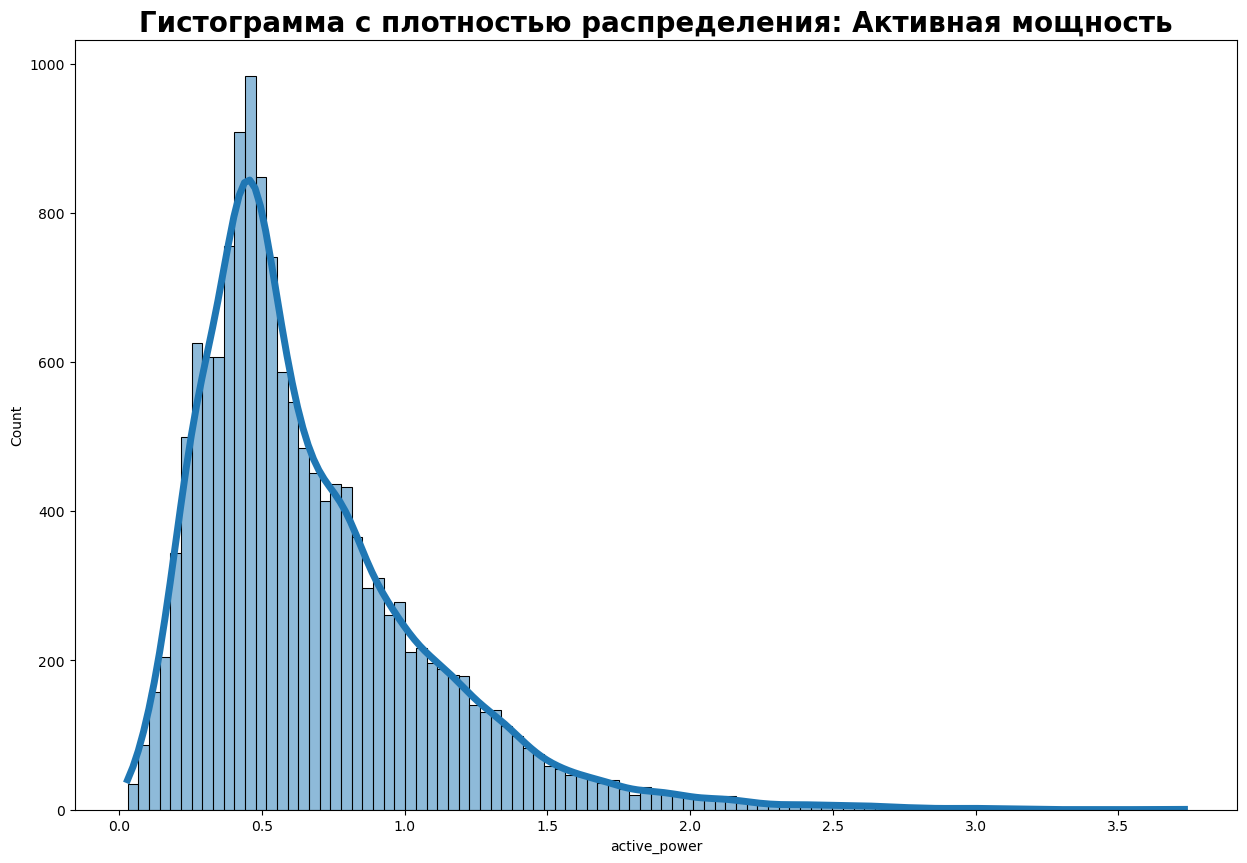

In [41]:
hist_col(df_arc['active_power'], 'Активная мощность')

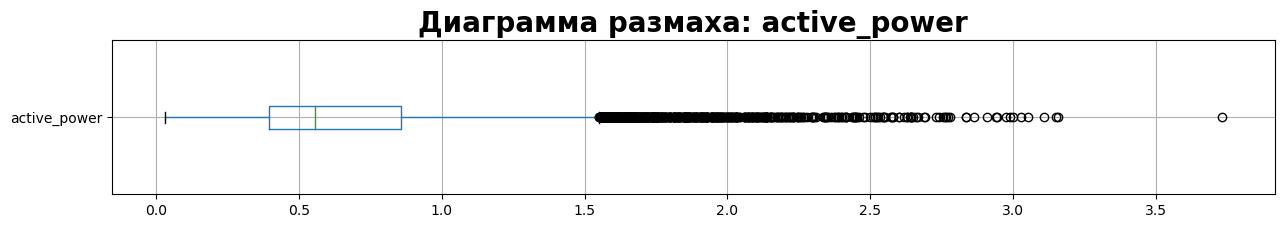

In [42]:
boxplot_col(df_arc, 'active_power')

Распределение со скошенностью вправо. Основная часть значений сосредоточена в промежутке от 0 до 1.5

Возможны выбросы после 1.5

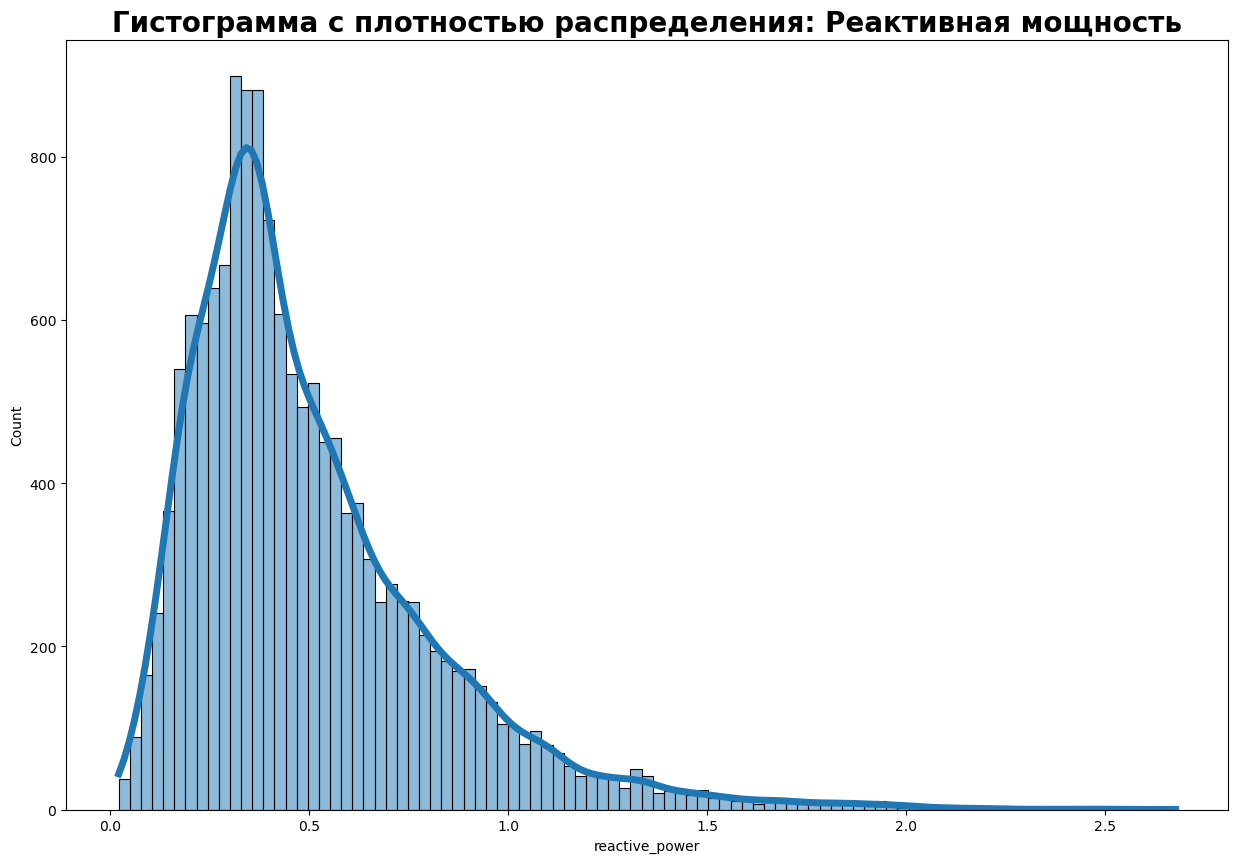

In [43]:
hist_col(df_arc['reactive_power'], 'Реактивная мощность')

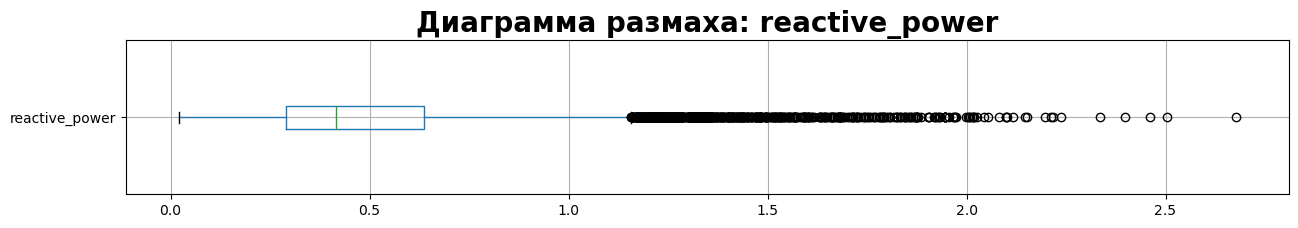

In [44]:
boxplot_col(df_arc, 'reactive_power')

Распределение со скошенностью вправо. Основная часть значений сосредоточена в промежутке от 0 до 1

Возможны выбросы после 1.2

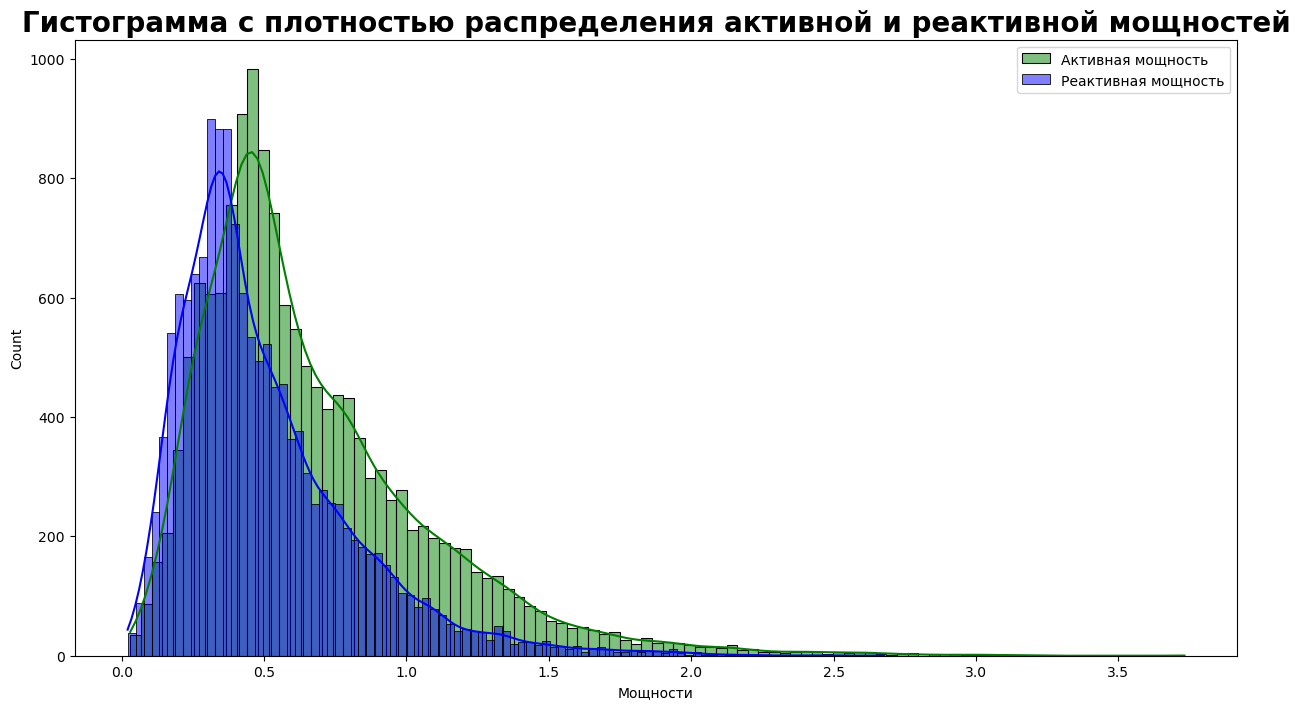

In [45]:
plt.figure(figsize=(15, 8))
sns.histplot(df_arc, x='active_power', kde=True, color='green',  label='Активная мощность');
sns.histplot(df_arc, x='reactive_power', kde=True, color='blue',  label='Реактивная мощность');
plt.legend()
plt.title('Гистoграмма с плотностью распределения активной и реактивной мощностей', fontweight='bold', fontsize=20);
plt.xlabel('Мощности');

Распределение активной и реактивной мощности практически идентичное

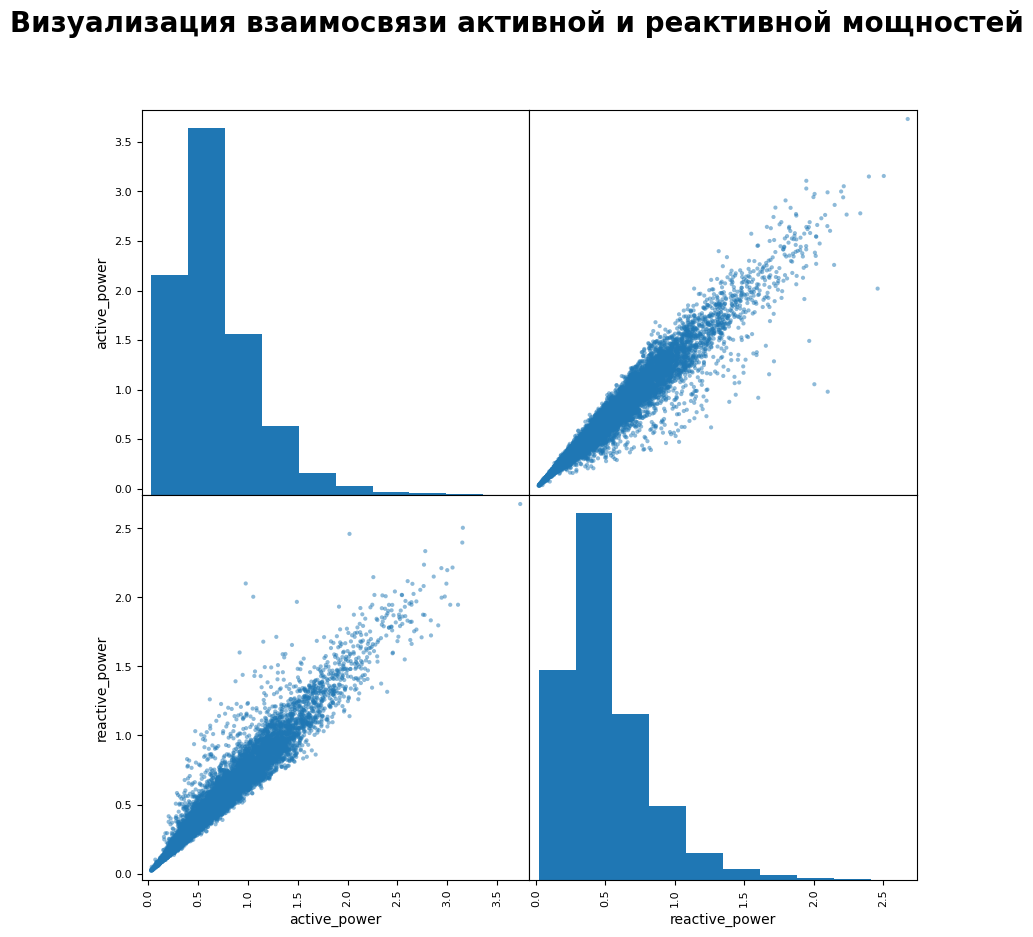

In [46]:
pd.plotting.scatter_matrix(df_arc[df_arc['reactive_power'] > 0][['active_power', 'reactive_power']], figsize=(10, 10))
plt.suptitle('Визуализация взаимосвязи активной и реактивной мощностей',  fontweight='bold', fontsize=20);

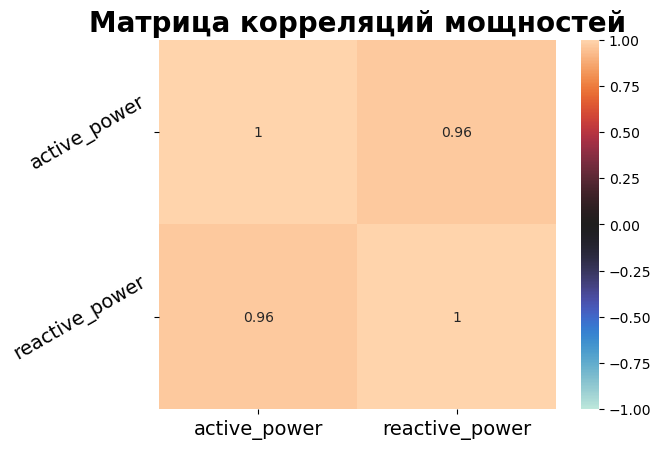

In [47]:
df_arc_corr = df_arc.iloc[:, 1:].corr()
sns.heatmap(df_arc_corr, center=0, annot=True, vmin=-1, vmax=1).set_yticklabels(
    labels=['active_power', 'reactive_power'], rotation=30)
plt.title('Матрица корреляций мощностей', fontweight='bold', fontsize=20);
plt.tick_params(labelsize=14)

plt.show()

Корреляция 0.96 и визуализация взаимасвязм указывают на очень сильную положительную линейную корреляцию между активной и реактивной мощностями.

Сразу посчитаем время нагрева дугой.

In [48]:
# Новый столбец о времени нагрева в секундах 
df_arc['arc_heating_seconds'] = (df_arc['start_of_arc_heating'] - df_arc['end_of_arc_heating']).dt.seconds

In [49]:
df_arc['arc_heating_seconds'].describe()

count   14875.00
mean    86228.32
std        98.19
min     85493.00
25%     86186.00
50%     86253.00
75%     86293.00
max     86389.00
Name: arc_heating_seconds, dtype: float64

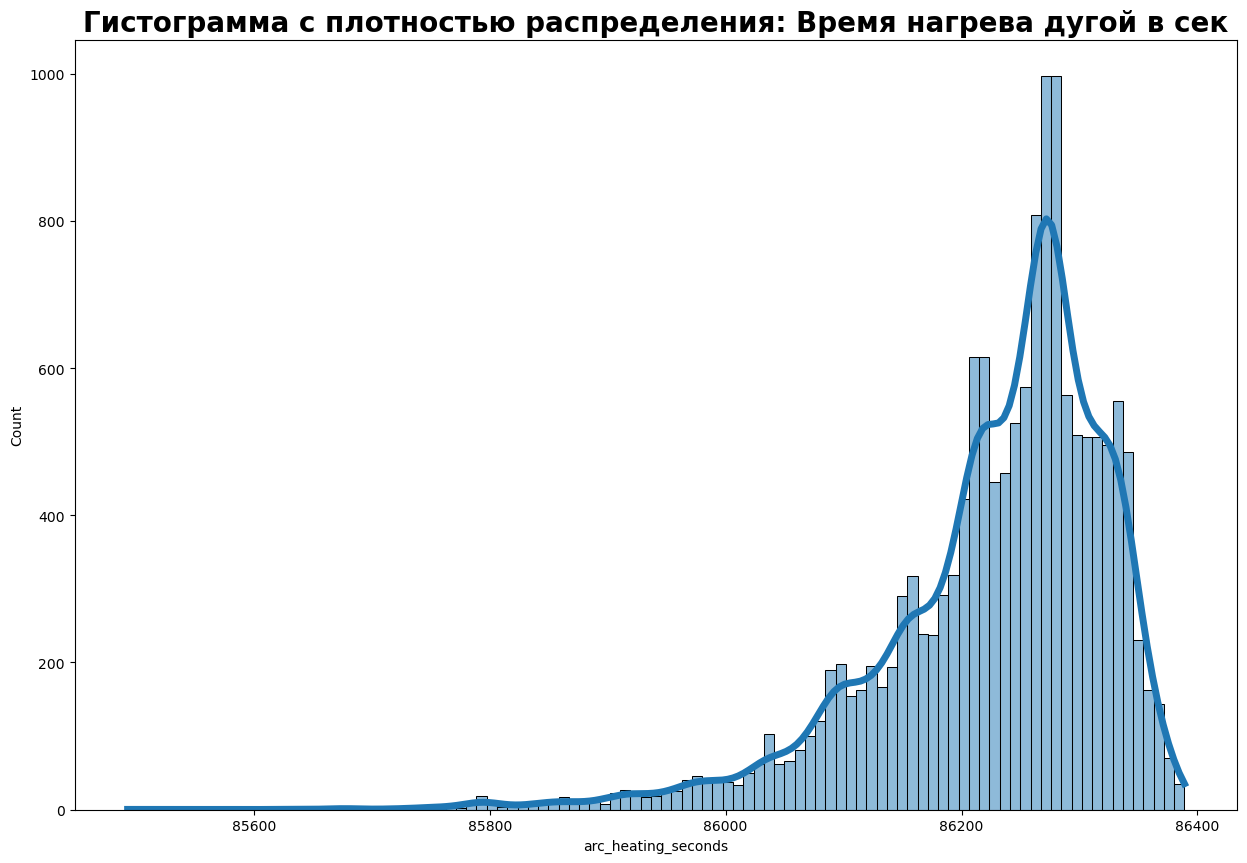

In [50]:
hist_col(df_arc['arc_heating_seconds'], 'Время нагрева дугой в сек')

Время нагрева дугой сосредоточено в промежутке: от 86186 до 86293 сек. Распределение времени нагрева со скошенностью влево, заметно нетипично короткое время нагрева.

## Данные о подаче сыпучих материалов (объём)

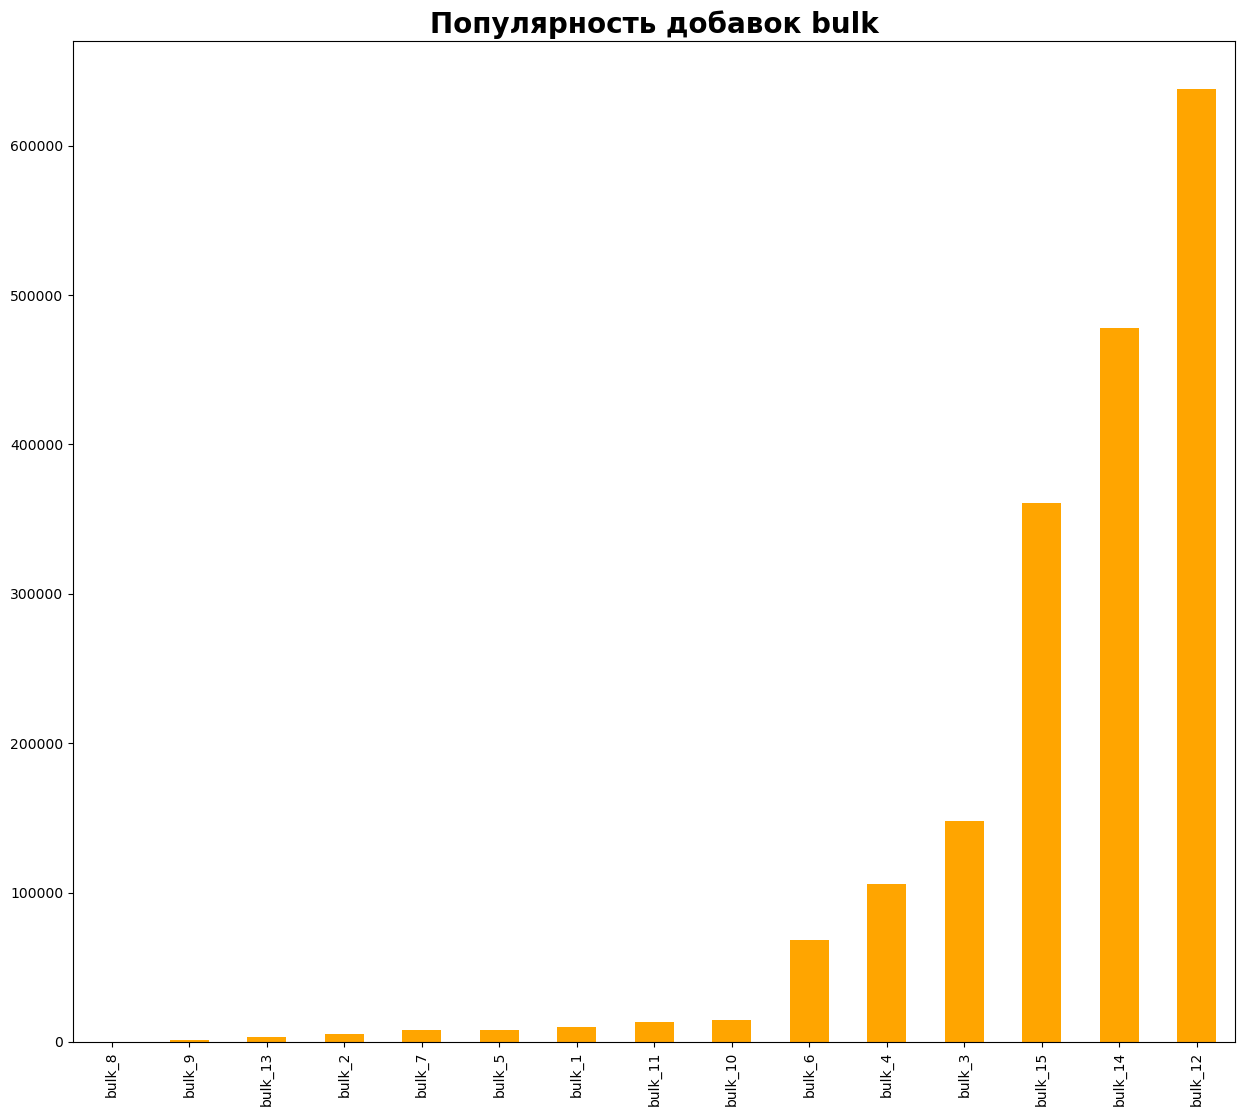

In [51]:
plt.figure(figsize=(15,13))
df_bulk.iloc[:, 1:].sum().sort_values().plot(kind='bar', color='orange')
plt.title('Популярность добавок bulk', fontweight='bold', fontsize=20)
plt.show()

Визуально понятно, что некоторые добавки используются очень редко. Самыми используемыми являются 15, 14 и 12 bulk

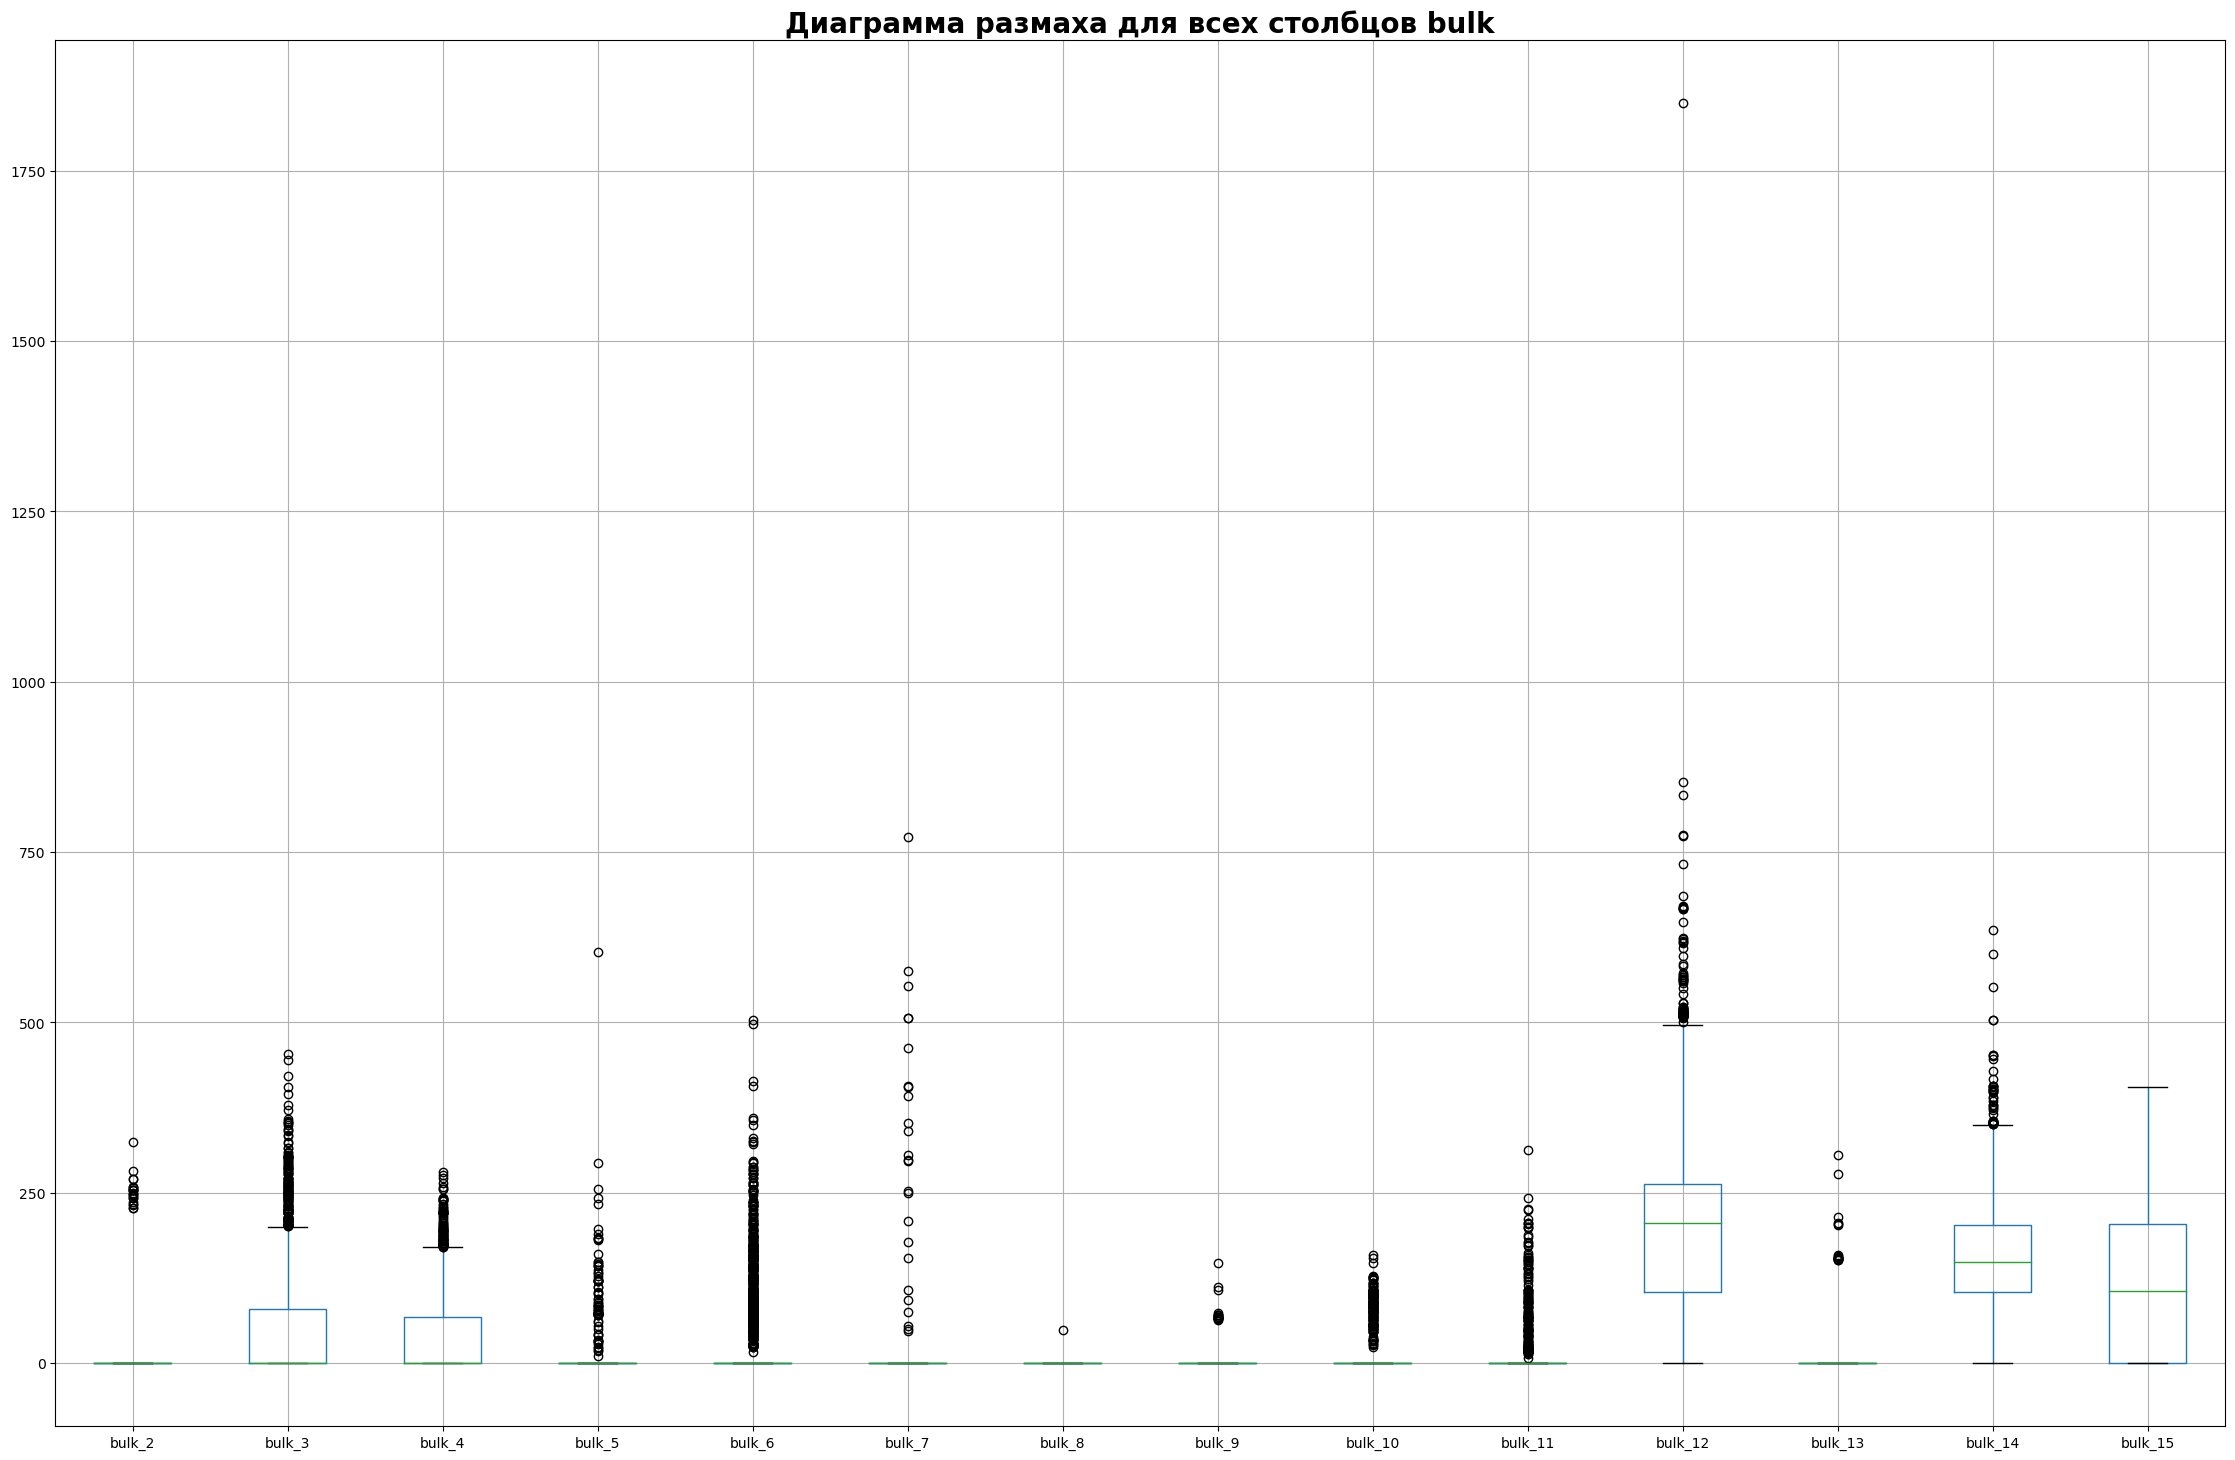

In [52]:
boxplot_full(df_bulk.iloc[:, 1:], 'bulk')

В некоторых столбцах наблюдаются выбросы, например, в 12 и 14. 

В дальнейшем при подготовки выборок необходимо обратить внимание на популярность добавок и их выбивающиеся значения.

## Данные о подаче сыпучих материалов (время)

Выведем число операций по каждому типу сыпучих материалов:

In [53]:
bulk_counts = {}
for col in df_bulk_time.columns[1:]:
    bulk_counts[col] = df_bulk_time[col].count()

print(bulk_counts)

{'bulk_1': 252, 'bulk_2': 22, 'bulk_3': 1298, 'bulk_4': 1014, 'bulk_5': 77, 'bulk_6': 576, 'bulk_7': 25, 'bulk_8': 1, 'bulk_9': 19, 'bulk_10': 176, 'bulk_11': 177, 'bulk_12': 2450, 'bulk_13': 18, 'bulk_14': 2806, 'bulk_15': 2248}


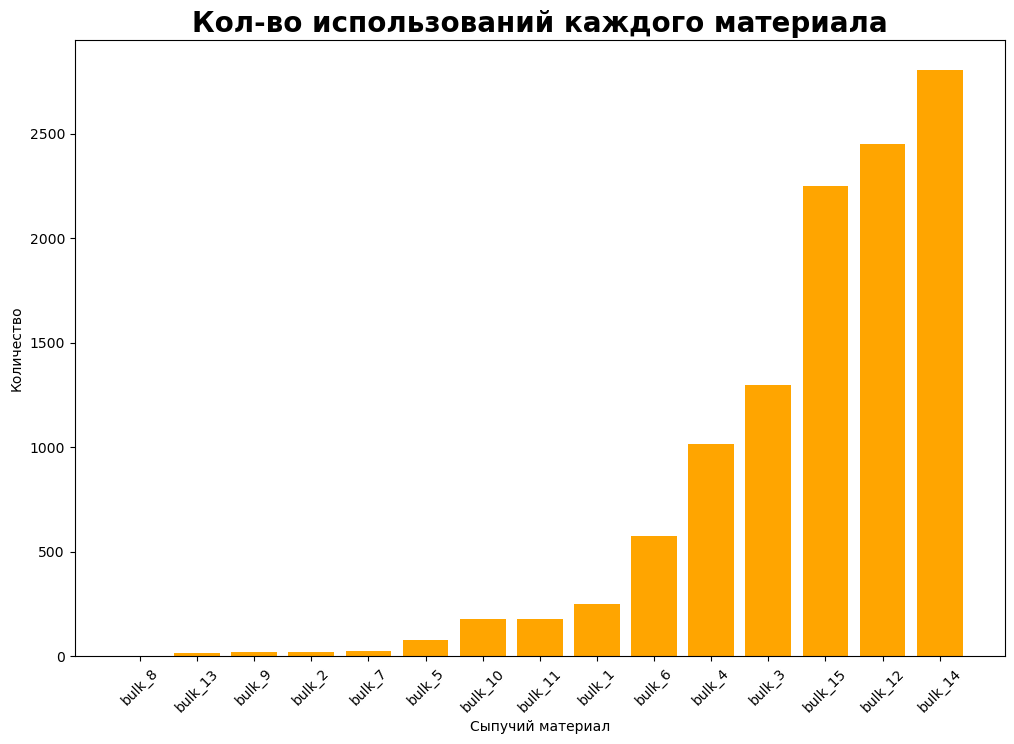

In [54]:
fig, ax = plt.subplots(figsize=(12, 8))
sorted_keys = sorted(bulk_counts.keys(), key=lambda k: bulk_counts[k])
ax.bar(sorted_keys, [bulk_counts[k] for k in sorted_keys], color='orange')
ax.set_title('Кол-во использований каждого материала', fontweight='bold', fontsize=20);
ax.set_xlabel('Сыпучий материал')
ax.set_ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

Замер времени по добавлению материала соответствует объёму материала: частота использования материала 15, 12, 14 выше так же, как и объём у данных материалов, что логично, больше. Некоторые материалы подаются очень редко, данных о времени подачи довольно мало: bulk 8, 13, 9, 2, 7, 5, 10, 11, 1.

In [55]:
df_bulk_time.fillna(0, inplace=True)

## Данные о продувке сплава газом

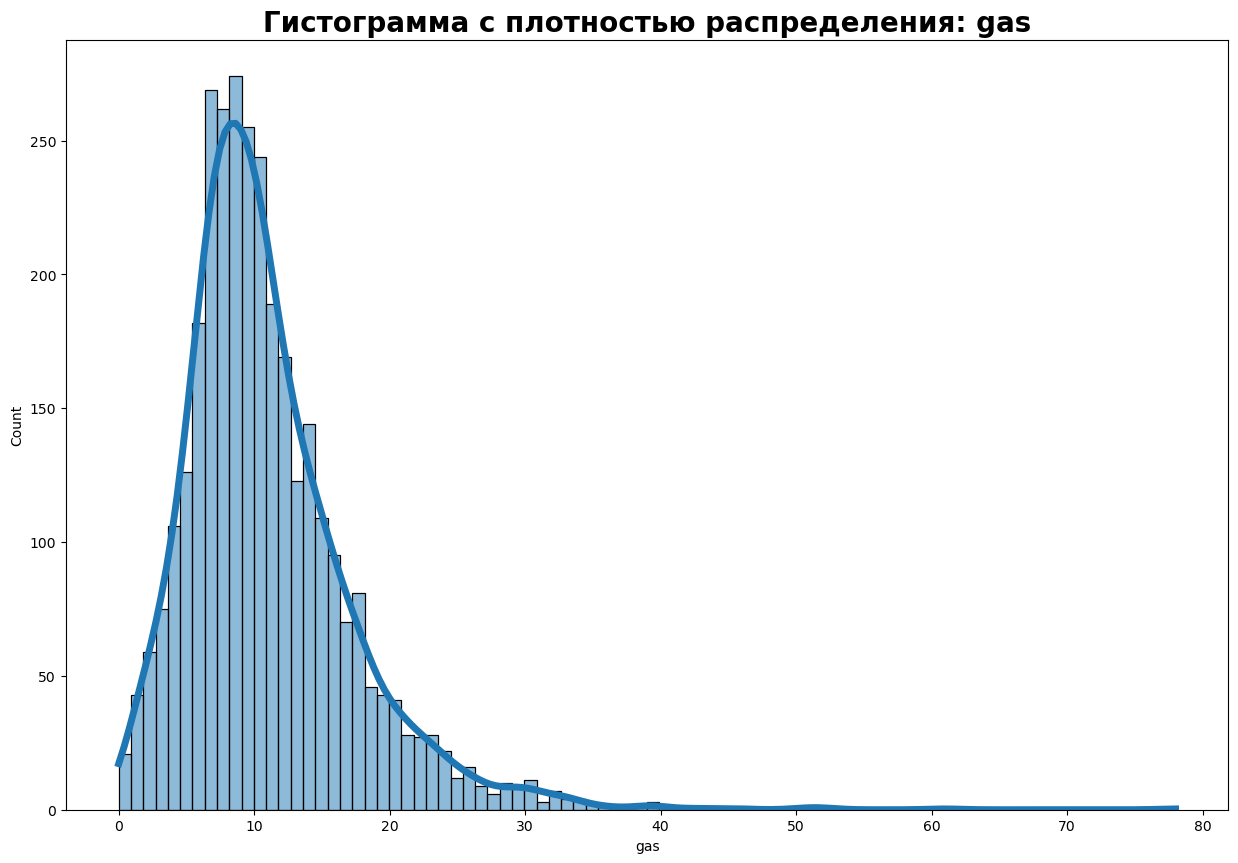

In [56]:
hist_col(df_gas['gas'], 'gas')

In [57]:
print(df_gas['gas'].describe())

count   3239.00
mean      11.00
std        6.22
min        0.01
25%        7.04
50%        9.84
75%       13.77
max       78.00
Name: gas, dtype: float64


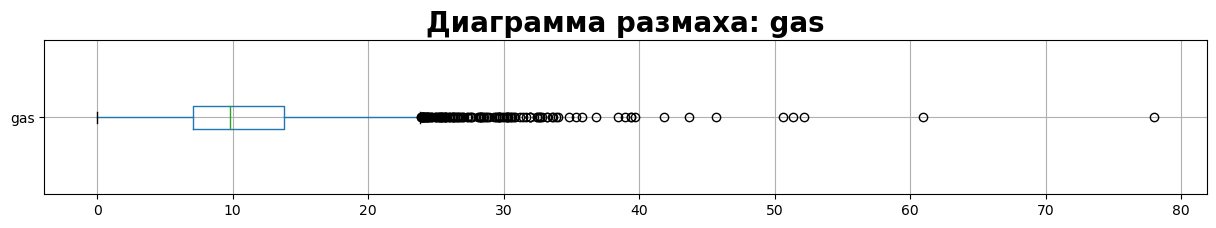

In [58]:
boxplot_col(df_gas, 'gas')

Распределение продувки газом со скошенность вправо и с выбросами.

## Результаты измерения температуры

**Key**

In [59]:
count_uniq_key(df_temp)

Количество уникальных ключей в таблице 3216
Количество строк в таблице 13006


Строк больше чем ключей, тк на каждый ключ(партию) проводилось несколько замеров температуры.

In [60]:
df_temp['key'].value_counts().describe()

count   3216.00
mean       4.04
std        2.30
min        1.00
25%        3.00
50%        4.00
75%        5.00
max       16.00
Name: key, dtype: float64

**Temp**

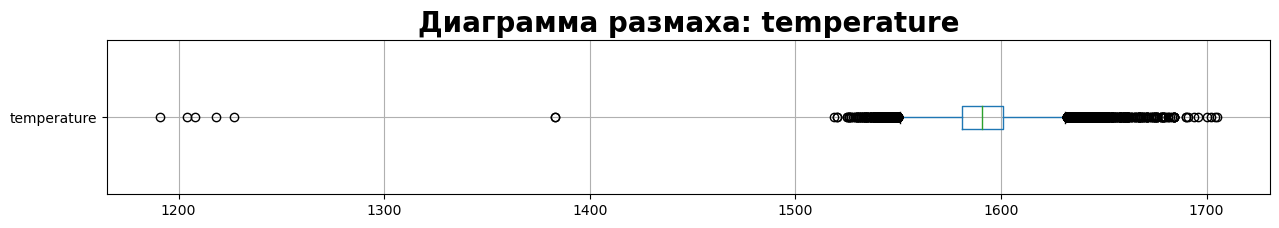

In [61]:
boxplot_col(df_temp, 'temperature')

Из открытых источников можно узнать, что температура плавления стали находится в диапазоне от 1350 до 1535°С. К тому же, выбросы от 1200 до 1500 распределены нехарактерно и нетипично, от них можно избавиться.

In [62]:
df_temp = df_temp[df_temp['temperature'] > 1400]

print(df_temp['temperature'].min())

1519.0


In [63]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12999 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               12999 non-null  int64         
 1   measurement_time  12999 non-null  datetime64[ns]
 2   temperature       12999 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.2 KB


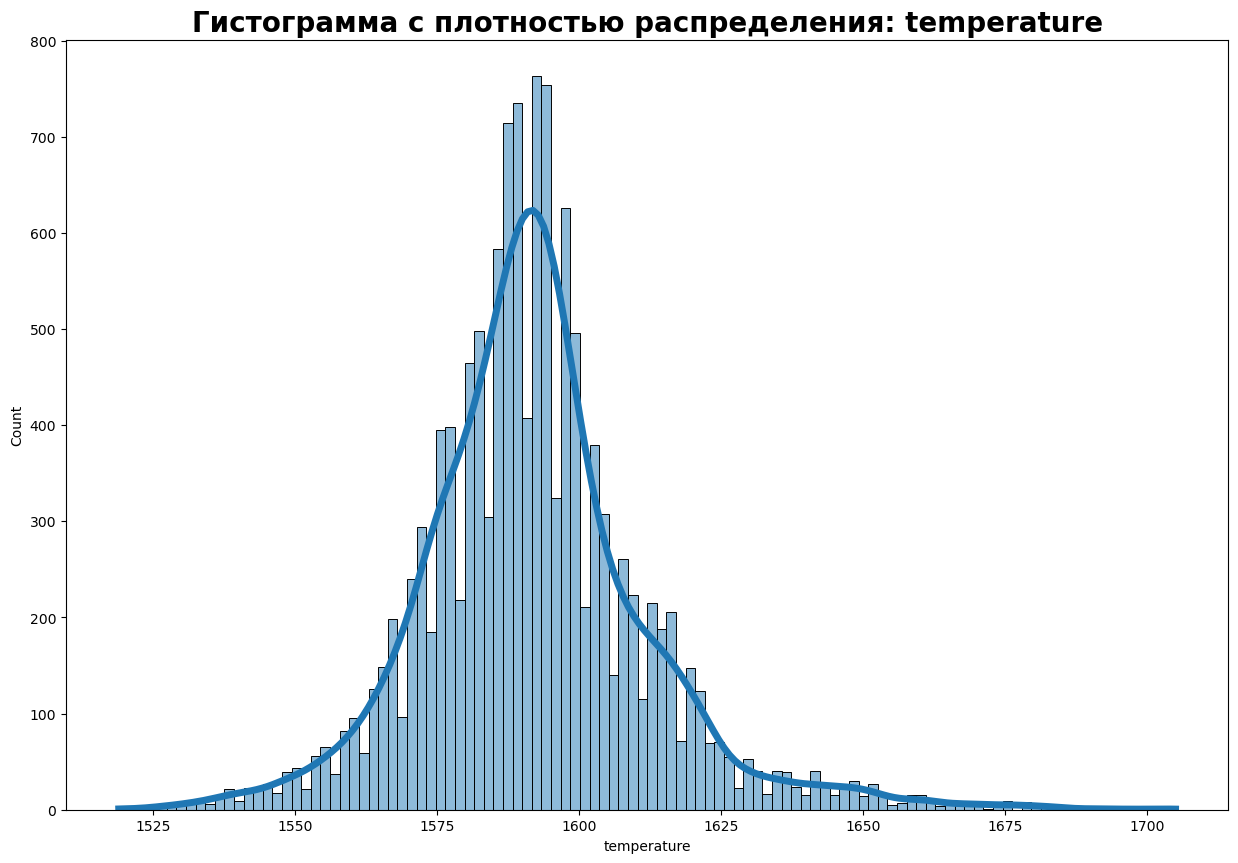

In [64]:
hist_col(df_temp['temperature'], 'temperature')

Распределение температуры нормальное, с небольшим хвостом справа.

## Данные о проволочных материалах (объём)

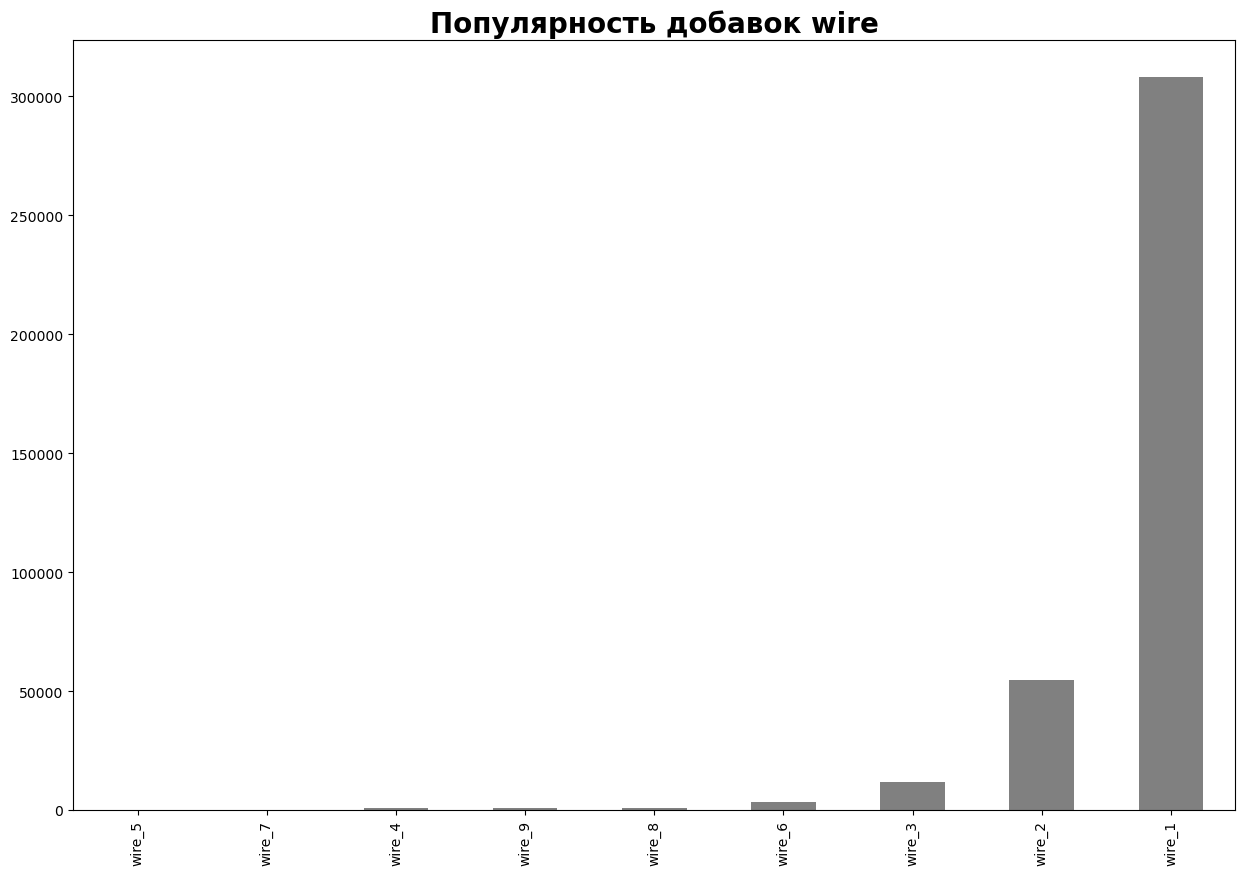

In [65]:
plt.figure(figsize=(15,10))
df_wire.iloc[:, 1:].sum().sort_values().plot(kind='bar', color='gray')
plt.title('Популярность добавок wire', fontweight='bold', fontsize=20)
plt.show()

Самым популярным в использовании проволочных материалов является wire_1. Значительно меньше, но все же используется и wire_2. Практически совсем не используютсяя wire 5, 7, 4, 9, 8, 6 - стоит обратить на это внимание при конструировании признаков.

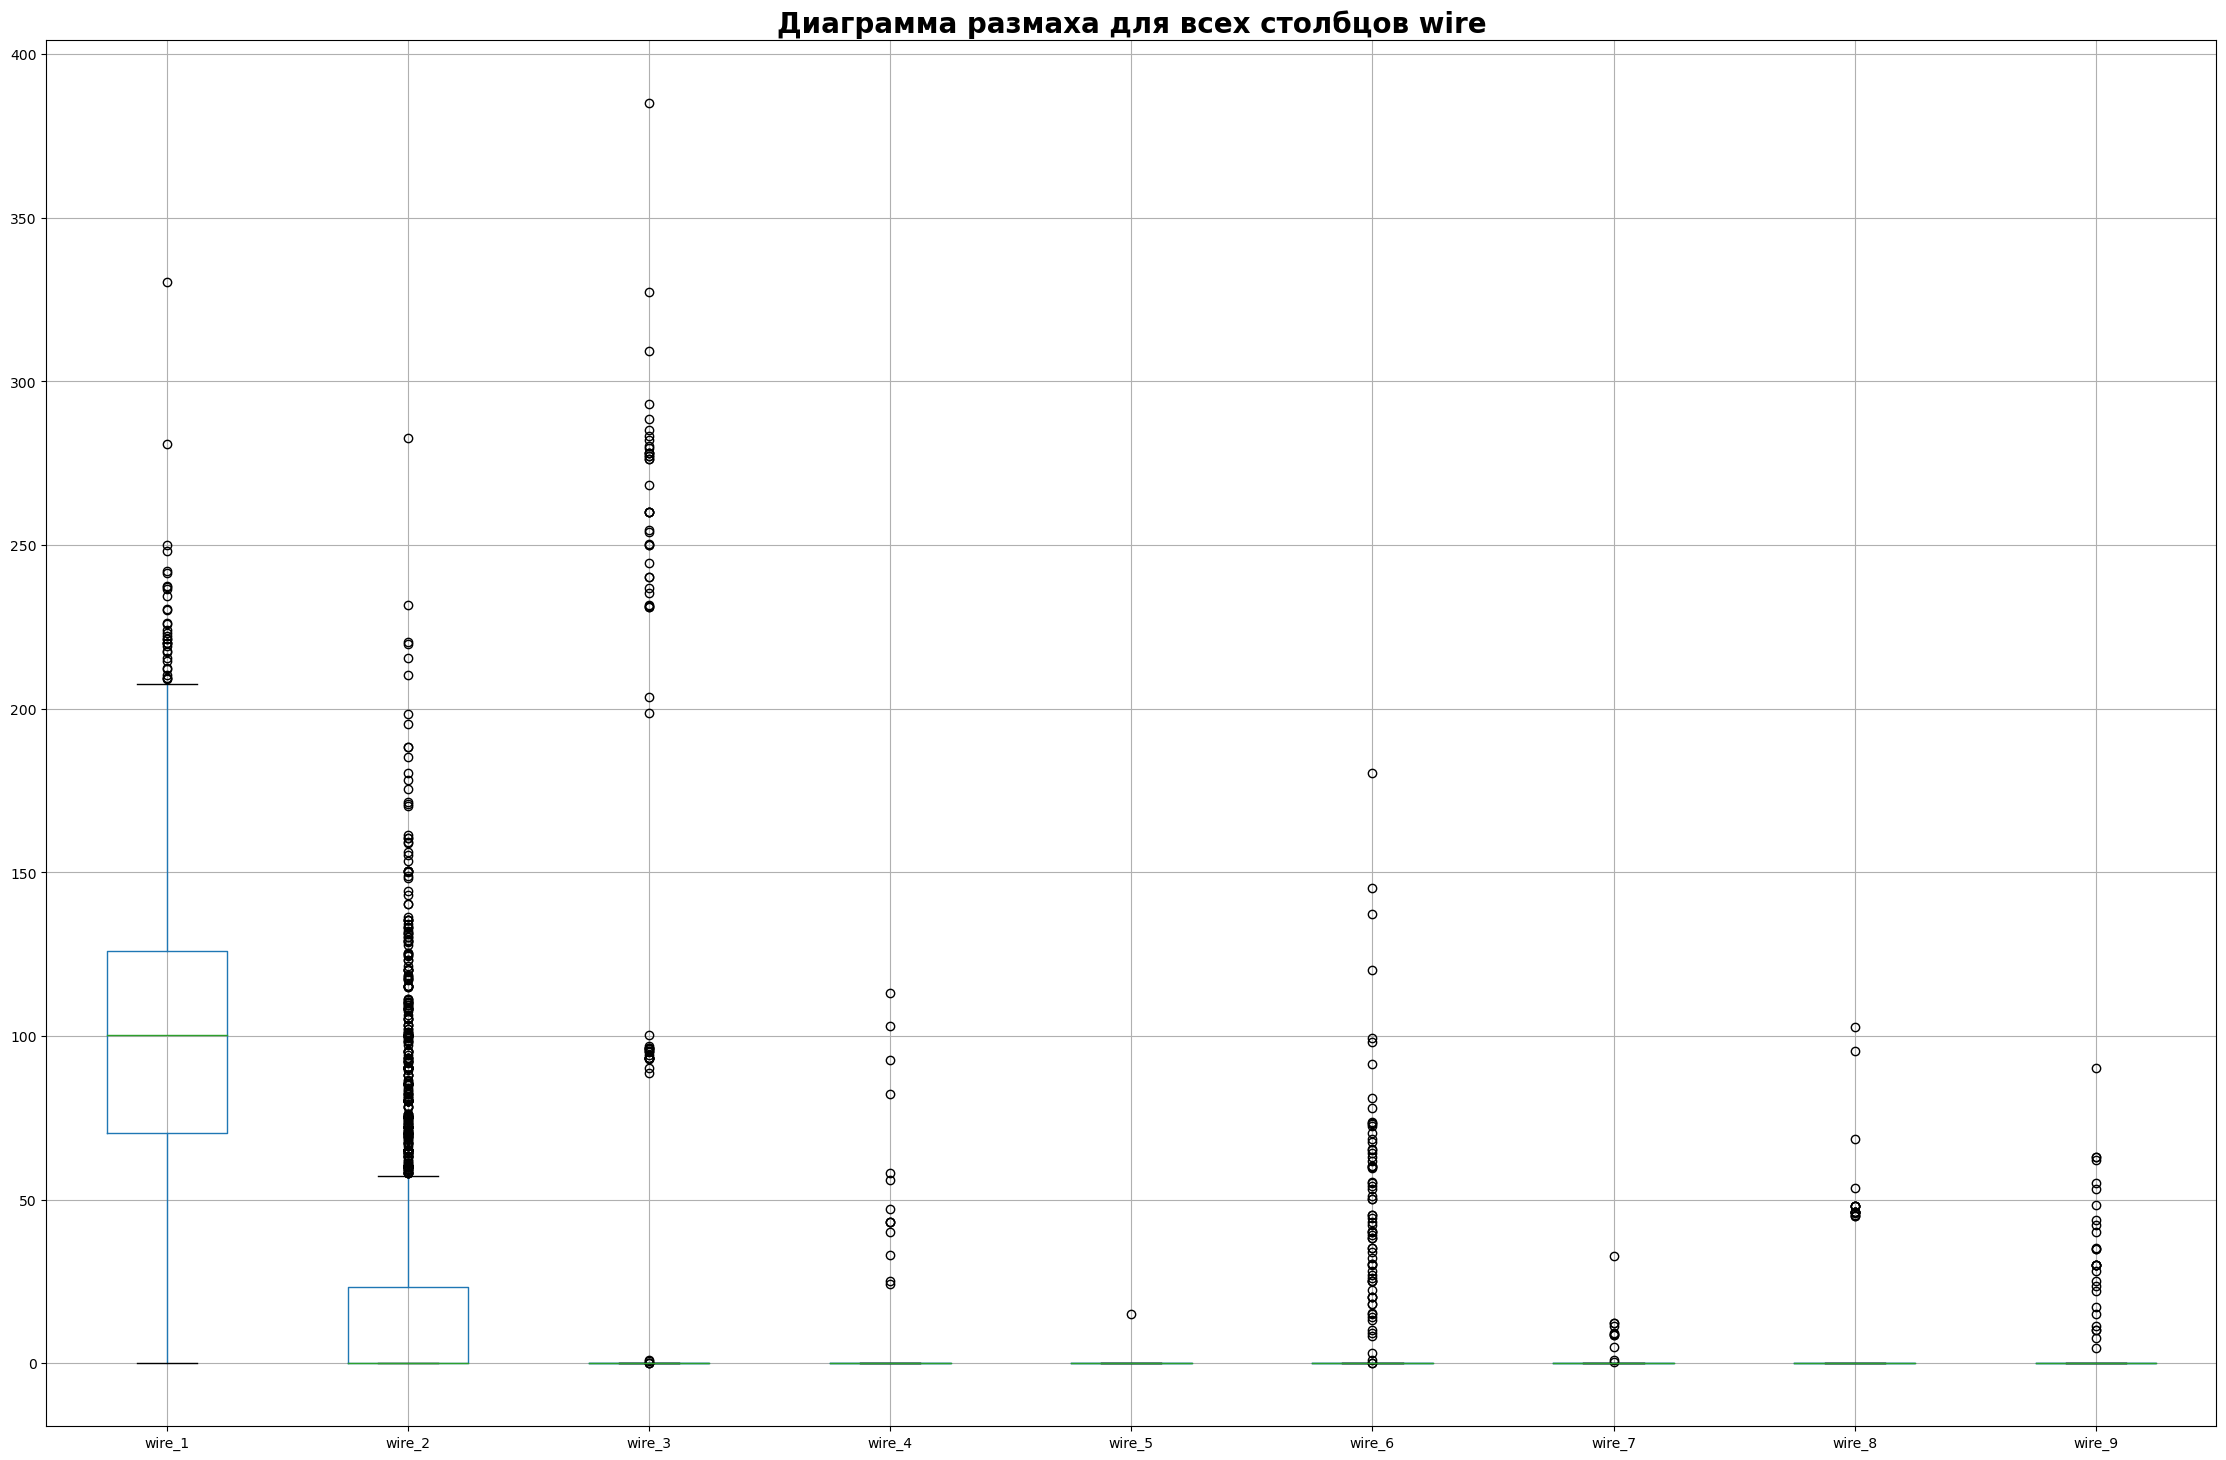

In [66]:
boxplot_full(df_wire.iloc[:, 0:], 'wire')

На диаграмме размаха отчетливо видно скопление выбросов в wirе_2. Аомально большие значения встречаются у wire_3. По остальным материалам оценить выбросы это или нормально распределение данных тяжело, тк записей по материалам очень мало.

## Данные о проволочных материалах (время)

In [67]:
# Создаем словарь с количеством операций по каждому типу bulk
wire_counts = {}
for col in df_wire_time.columns[1:]:
    wire_counts[col] = df_wire_time[col].count()

print(wire_counts)

{'wire_1': 3055, 'wire_2': 1079, 'wire_3': 63, 'wire_4': 14, 'wire_5': 1, 'wire_6': 73, 'wire_7': 11, 'wire_8': 19, 'wire_9': 29}


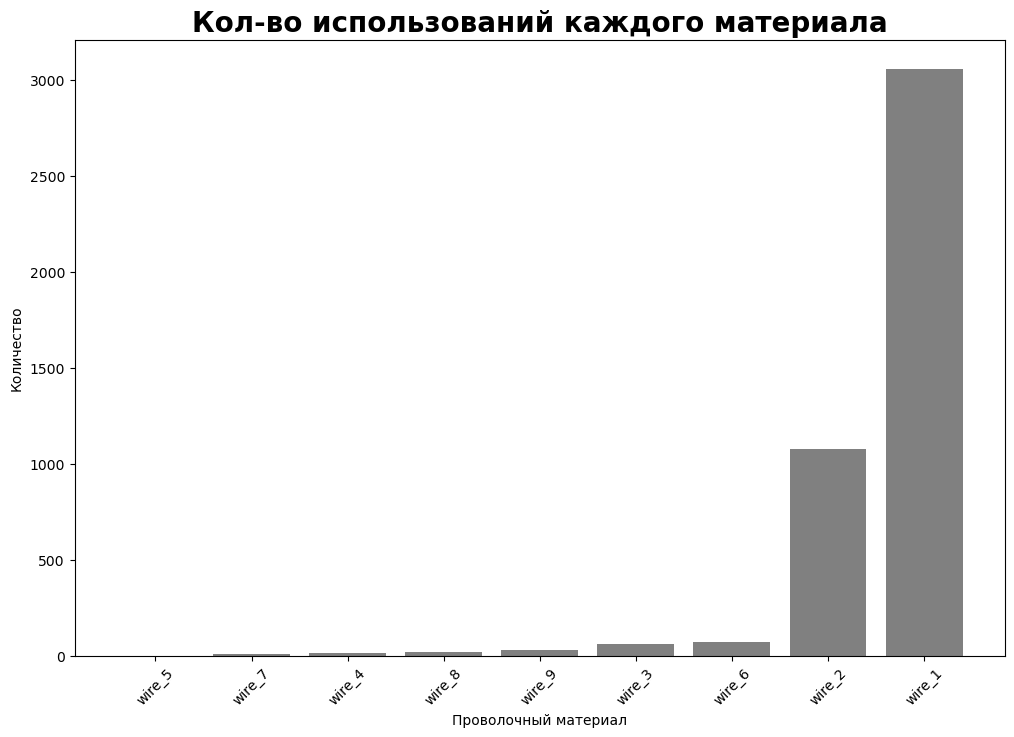

In [68]:
fig, ax = plt.subplots(figsize=(12, 8))
sorted_keys_2 = sorted(wire_counts.keys(), key=lambda k: wire_counts[k])
ax.bar(sorted_keys_2, [wire_counts[k] for k in sorted_keys_2], color='gray')
ax.set_title('Кол-во использований каждого материала', fontweight='bold', fontsize=20);
ax.set_xlabel('Проволочный материал')
ax.set_ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

Замер времени по добавлению материала соответствует объёму материала: частота использования проволочного материала 1, 2 выше так же, как и объём у данных материалов, что логично, больше. Некоторые материалы подаются очень редко, данных о времени подачи довольно мало: wire 5, 7, 4, 8, 9, 3, 6.

In [69]:
df_wire_time.fillna(0, inplace=True)

**Промежуточный итог:**
Мы рассмотрели распределение данных, возможные аномалиии и выбросы, а также взаимосвязи.

Данные об электродах:
- Осуществлялось несколько стадий нагрева для партии
- Активная и реактивная мощности распределены со скошенностью вправо практически идентично. Видны выбросы после 1.5 и 1.2 соответственно
- Активная и реактивная мощности имеют сильную положительную линейную корреляцию между друг другом 
- Время нагрева дугой колеблется сосредоточено в промежутке от 86.2 тыс сек до 86.3 тыс сек

Данные о сыпучих материалах, обьем и время:
- Некоторые добавки используются очень редко. Самыми используемыми добавками являются bulk 12, 14 и 15
- Возможно выбросы в добавках 12 и 14
- Данных о времени подачи материалов 8, 13, 9, 2 очень мало.

Данные о продувке сплава газом:
- Продувка распределена со скошенностью вправо и с выбросами. Большая часть значений сосредоточена в промежутке от 7 до 13.

Результаты измерения температуры:
- Осуществлялось несколько замеров температуры для партии
- Обнаружены и удалены аномально низкие температуры (порог в 1400)
- Температура распределена нормально с небольшим хвостом справа (возможны выбросы)

Данные о проволочных материалах:
- Большинство добавок практически не используются
- Самая популярная добавка - wire 1, менее популярная, но тем не менее используется - wire 2
- В данных о  wire 2 присутствуют выбросы
- Следующие материалы подаются редко (кол-во замеров времени низкое): wire 5, 7, 4, 8, 9, 3, 6

Далее будем готовить выборки для обучения модели, необходимо обратить внимание на следующие аспекты:
- Кол-во замеров температуры в партиях: необходимо оставить партии, в которых будут первый и последний замер (требование хаказчика)
- Взаимосвязи в объединёных данных
- Информативность признаков
- Доп. очистка данных при необходимости

# Подготовка данных к обучению

## Генерация доп признаков и удаление неинформативных признаков

###  Данные об электродах

**В данные об электродах добавим 2 столбца:**
1. Полная мощность
2. Энергия

*Заметим, что единицы измерения мощностей не указаны, но мы можем интерпретировать результаты как N-ед.измерения*

*Полная мощность* рассчитывается по формуле:
$$S = \sqrt{Q^2 + p^2}$$
где:

S - полная мощность

Q - активная мощность

p - реактивная мощность

In [70]:
df_arc['full_power'] = (df_arc['active_power'] ** 2 + df_arc['reactive_power'] ** 2).apply(sqrt)

Для расчета энергии необходимо знать время нагрева. Мы уже рассчитали его в столбце arc_heating_seconds.

*Энергия* может быть вычислена по следующей формуле:

$$E = P × t$$

где:

E - энергия

P - активная мощность

t - время нагрева

In [71]:
df_arc['energy'] = df_arc['arc_heating_seconds'] * df_arc['full_power']

In [72]:
# Проверим изменения

df_arc.head()

,key,start_of_arc_heating,end_of_arc_heating,active_power,reactive_power,arc_heating_seconds,full_power,energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.98,0.69,86172,1.19,102858.28
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.81,0.52,86215,0.96,82681.02
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.74,0.50,86228,0.90,77263.55
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.66,1.06,86035,1.97,169529.35
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.69,0.41,86252,0.81,69625.95


Соберём все данные по партии, чтобы в таблице не встречалось партий-дублей. Сразу исключим столбцы 'start_of_arc_heating' и 'end_of_arc_heating' - данные не информативны.

In [73]:
df_arc_grouped = pd.pivot_table(df_arc, values=[
    'active_power', 'reactive_power', 'full_power', 'arc_heating_seconds', 'energy'],
                                index='key',
                                aggfunc={'active_power': np.sum,
                                         'reactive_power': np.sum,
                                         'full_power': np.sum,
                                         'arc_heating_seconds': np.sum,
                                         'energy': np.sum}).reset_index()

In [74]:
print('Кол-во дубликатов по партиям: ', df_arc_grouped['key'].duplicated().sum())

Кол-во дубликатов по партиям:  0


In [75]:
df_arc_grouped.head()

,key,active_power,arc_heating_seconds,energy,full_power,reactive_power
0,1,4.88,430902,501958.14,5.83,3.18
1,2,3.05,344789,314411.06,3.65,2.00
2,3,2.53,431345,257770.68,2.99,1.60
3,4,3.21,344859,328815.84,3.81,2.06
4,5,3.35,344731,347490.34,4.04,2.25


Рассмотрим подробнее полную мощность

In [76]:
df_arc_grouped['full_power'].describe()

count   3214.00
mean       3.88
std        1.74
min        0.26
25%        2.67
50%        3.75
75%        4.86
max       21.56
Name: full_power, dtype: float64

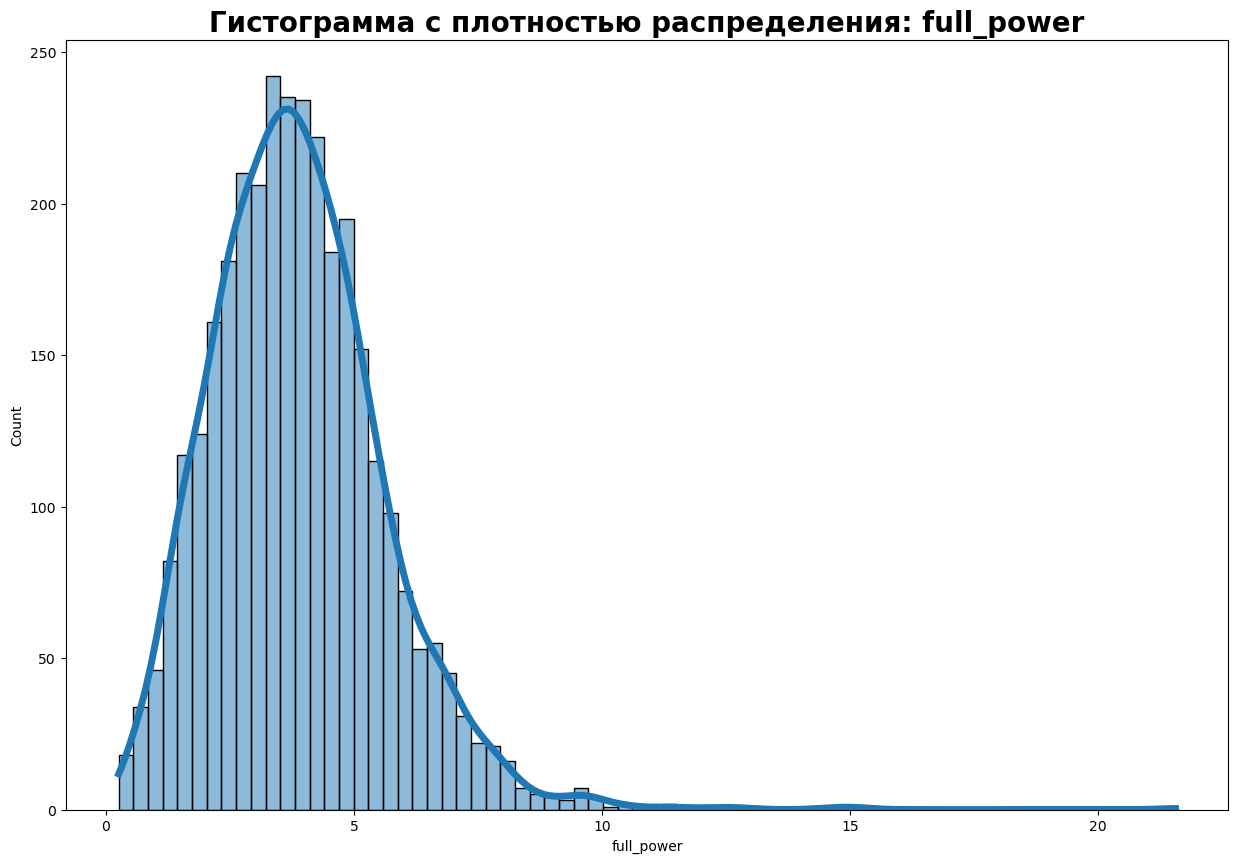

In [77]:
hist_col(df_arc_grouped['full_power'], 'full_power')

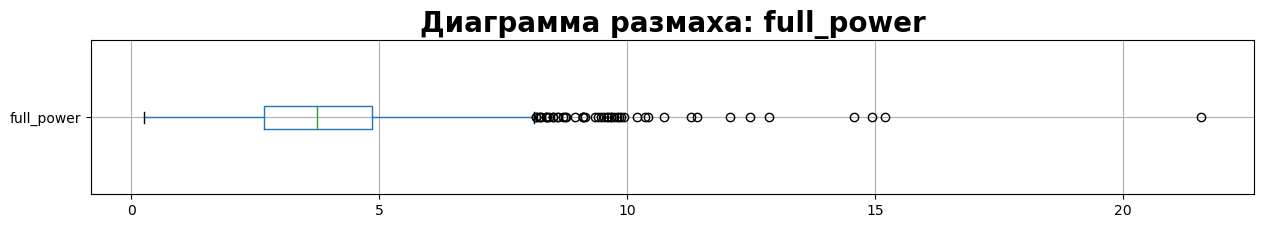

In [78]:
boxplot_col(df_arc_grouped, 'full_power')

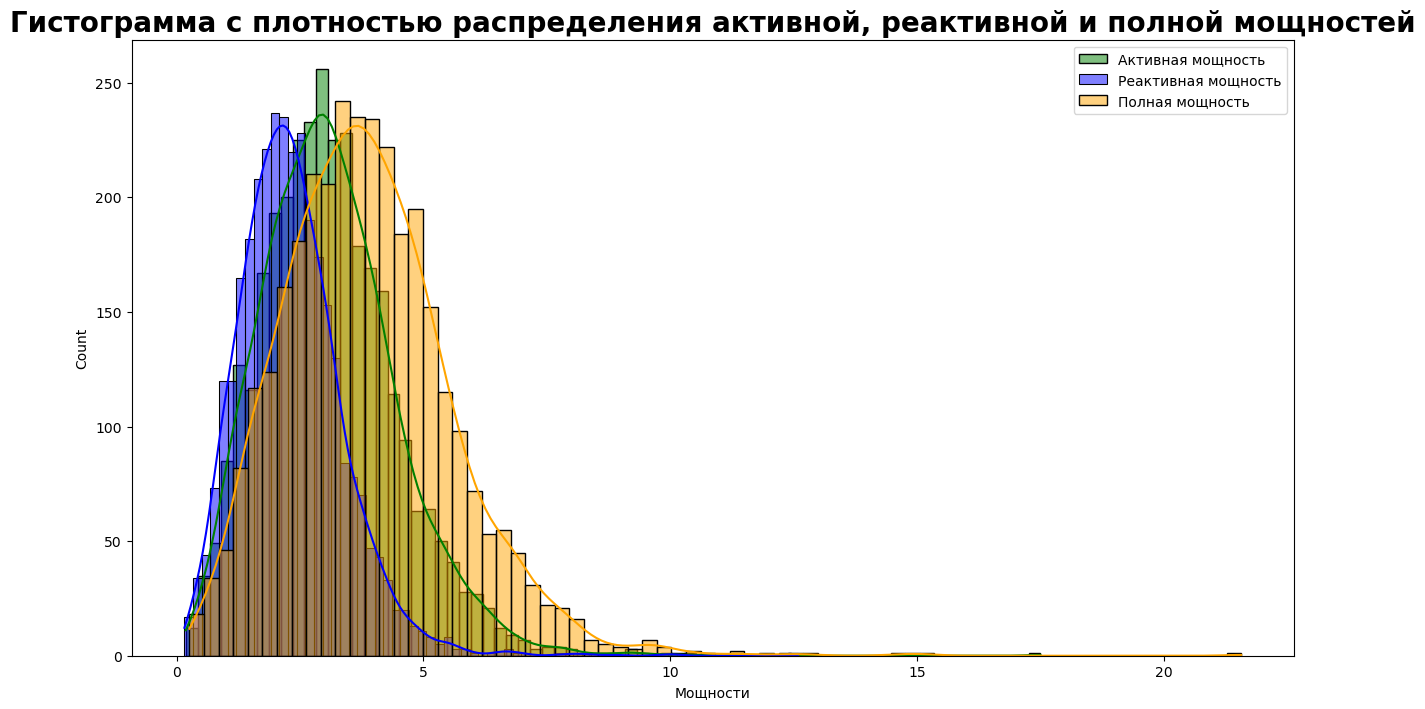

In [79]:
plt.figure(figsize=(15, 8))
sns.histplot(df_arc_grouped, x='active_power', kde=True, color='green', alpha=0.5, label='Активная мощность');
sns.histplot(df_arc_grouped, x='reactive_power', kde=True, color='blue', alpha=0.5, label='Реактивная мощность');
sns.histplot(df_arc_grouped, x='full_power', kde=True, color='orange', alpha=0.5, label='Полная мощность');
plt.legend()
plt.title('Гистoграмма с плотностью распределения активной, реактивной и полной мощностей', fontweight='bold', fontsize=20);
plt.xlabel('Мощности');

Распределение полной мощности получилось идентичным распределениям активной и реактивной мощностей: с выбросами и хвостом справа.

Рассмотрим подробнее энергию.

In [80]:
df_arc_grouped['energy'].describe()

count      3214.00
mean     334508.91
std      149775.47
min       22243.36
25%      230738.61
50%      323179.17
75%      418765.05
max     1852565.26
Name: energy, dtype: float64

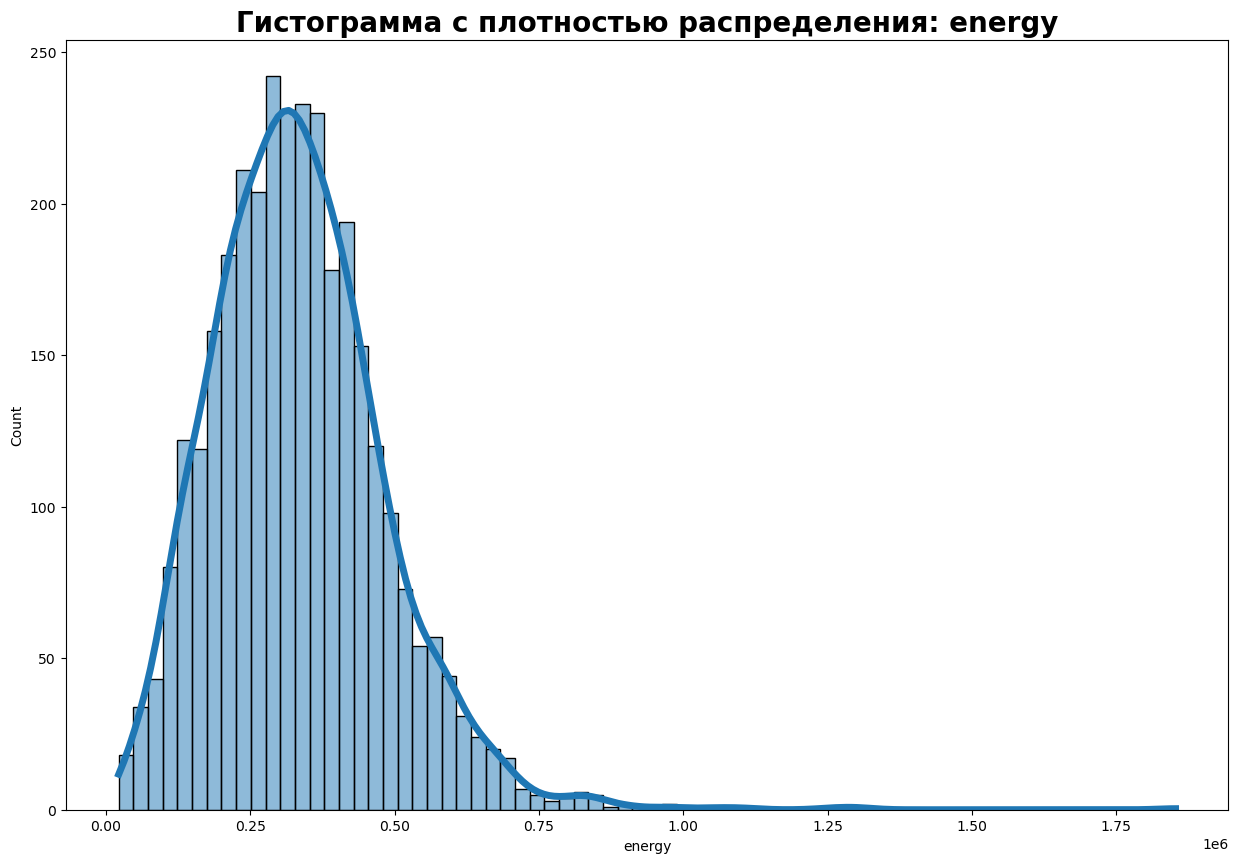

In [81]:
hist_col(df_arc_grouped['energy'], 'energy')

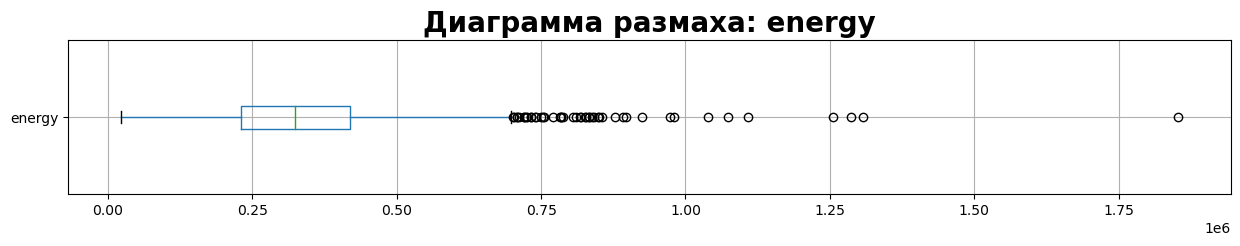

In [82]:
boxplot_col(df_arc_grouped, 'energy')

Данные по энергии сосредоточены в промежутке от 2 до 4 N-джоулей. Распределение также с выбросами и хвостом слева.

*Данные выбросы нужно будет удалить из тренировочной выборки.*

###  Данные температуре

Одно из требований заказчика: необходимо учитывать только те партии, в которых есть и начальный, и конечный замер температуры. Если что-то отсутствует, то такая партия не подходит для обучения.

Для этого исследуем:
1. Начальный замер температуры
2. Конечный замер температуры
3. Кол-во замеров температуры у партии


In [83]:
# Начальный замер температуры

df_temp_first = pd.merge(df_temp.groupby('key')['measurement_time'].agg('min'), df_temp, how='left', on='measurement_time')

df_temp_first.head()

,measurement_time,key,temperature
0,2019-05-03 11:16:18,1,1571.00
1,2019-05-03 11:37:27,2,1581.00
2,2019-05-03 12:13:17,3,1596.00
3,2019-05-03 12:52:57,4,1601.00
4,2019-05-03 13:23:19,5,1576.00


In [84]:
# Конечный замер температуры

df_temp_last = pd.merge(df_temp.groupby('key')['measurement_time'].agg('max'), df_temp, how='left', on='measurement_time')

In [85]:
# Кол-во замеров температуры партии

df_temp_count = df_temp.drop(['measurement_time'], axis=1).groupby('key').agg('count')

df_temp_count.head()

,temperature
key,
1,5
2,6
3,5
4,3
5,2


In [86]:
df_temp_full = pd.merge(df_temp_first[['key','temperature']], df_temp_last[['key','temperature']], how='outer', on='key')
df_temp_full = pd.merge(df_temp_full, df_temp_count, how='outer', on='key')

df_temp_full.rename(columns={'temperature_x': 'first_temp', 'temperature_y': 'last_temp', 
                             'temperature': 'measurement_counts'}, inplace=True)
df_temp_full.head(10)
print('Кол-во дубликатов по партиям: ', df_temp_full['key'].duplicated().sum())

Кол-во дубликатов по партиям:  0


In [87]:
print(df_temp_full[df_temp_full['measurement_counts'] == 1])

       key  first_temp  last_temp  measurement_counts
192    195     1583.00    1583.00                   1
276    279     1603.00    1603.00                   1
2477  2500     1539.00    1539.00                   1
2478  2501     1587.00    1587.00                   1
2479  2502     1583.00    1583.00                   1
...    ...         ...        ...                 ...
3210  3237     1569.00    1569.00                   1
3211  3238     1584.00    1584.00                   1
3212  3239     1598.00    1598.00                   1
3213  3240     1617.00    1617.00                   1
3214  3241     1586.00    1586.00                   1

[740 rows x 4 columns]


740 партий, не пригодных к дальнейшему использованию: на данных партиях проводился только 1 замер температуры, что не подходит нам по условию. Удалим эти партии.

In [88]:
df_temp_full = df_temp_full[df_temp_full['measurement_counts'] > 1]

print('Кол-во партий с одним измерением в очищенном датасете:', 
      len(df_temp_full[df_temp_full['measurement_counts'] == 1]))

Кол-во партий с одним измерением в очищенном датасете: 0


Столбец measurement_counts был необходим для исследования, но для обучения эта информация будет являться избыточной. Удалим его из таблицы.

In [89]:
df_temp_full = df_temp_full.drop(['measurement_counts'], axis=1)

df_temp_full.head()

,key,first_temp,last_temp
0,1,1571.00,1613.00
1,2,1581.00,1602.00
2,3,1596.00,1599.00
3,4,1601.00,1625.00
4,5,1576.00,1602.00


Есть ли партии, в которых температура на начальном замере равна температуре на конечном замере?

In [90]:
print(len(df_temp_full[df_temp_full['first_temp'] == df_temp_full['last_temp']]))

43


43 партии. Мы не уверены, насколько эти данные адекватны, но тк их мало и они могут "запутать модель", лучше удалим их.

In [91]:
df_temp_full = df_temp_full[df_temp_full['first_temp'] != df_temp_full['last_temp']]

print('Кол-во партий с одинаковой температурой на начальном и конечном замере:', 
      len(df_temp_full[df_temp_full['first_temp'] == df_temp_full['last_temp']]))

Кол-во партий с одинаковой температурой на начальном и конечном замере: 0


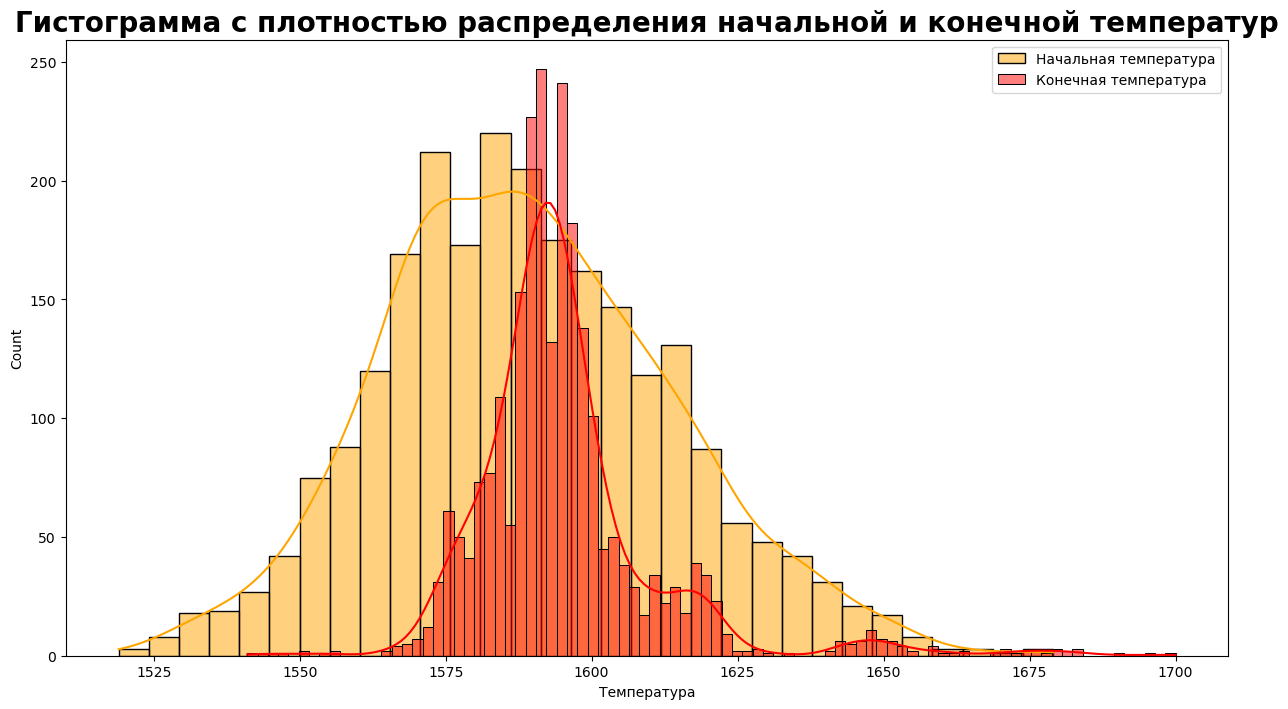

In [92]:
plt.figure(figsize=(15, 8))
sns.histplot(df_temp_full, x='first_temp', kde=True, color='orange', alpha=0.5, label='Начальная температура');
sns.histplot(df_temp_full, x='last_temp', kde=True, color='red', alpha=0.5, label='Конечная температура');
plt.legend()
plt.title('Гистoграмма с плотностью распределения начальной и конечной температур', fontweight='bold', fontsize=20);
plt.xlabel('Температура');

*Данные успешно очищены от негодных к партий*

###  Удаление неинформативных признаков: сыпучие и проволочные материалы

Для **сыпучих материалов** поставим границу в суммарном объёме в 50000: так мы не сильно урежем данные и уберём редкие добавки.

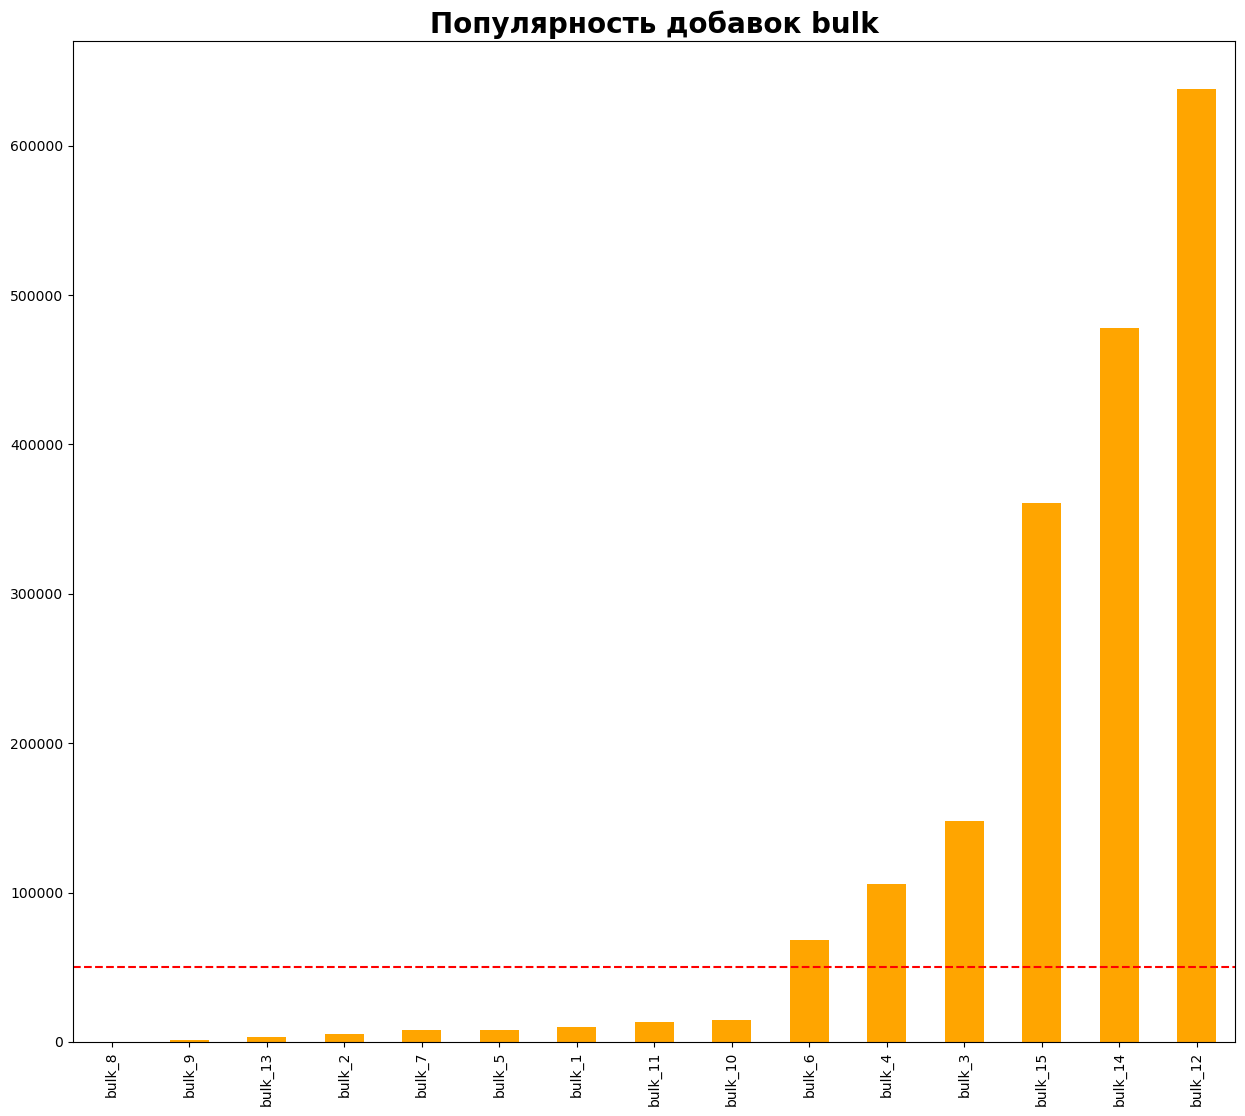

In [93]:
plt.figure(figsize=(15,13))
df_bulk.iloc[:, 1:].sum().sort_values().plot(kind='bar', color='orange')
plt.title('Популярность добавок bulk', fontweight='bold', fontsize=20)
plt.axhline(y=50000, color='r', linestyle='--')
plt.show()

In [94]:
df_bulk_new = df_bulk[['key', 'bulk_6', 'bulk_4', 'bulk_3', 'bulk_15', 'bulk_14', 'bulk_12']]

df_bulk_new.head()

,key,bulk_6,bulk_4,bulk_3,bulk_15,bulk_14,bulk_12
0,1,0.00,43.00,0.00,154.00,150.00,206.00
1,2,0.00,73.00,0.00,154.00,149.00,206.00
2,3,0.00,34.00,0.00,153.00,152.00,205.00
3,4,0.00,81.00,0.00,154.00,153.00,207.00
4,5,0.00,78.00,0.00,152.00,151.00,203.00


Для **проволочных материалов** поставим границу в 3000.  Мы оставим 1 менее используемый материал wire_6, но тем не менее, его объём в 3 раза больше других практически не используемых материалов.

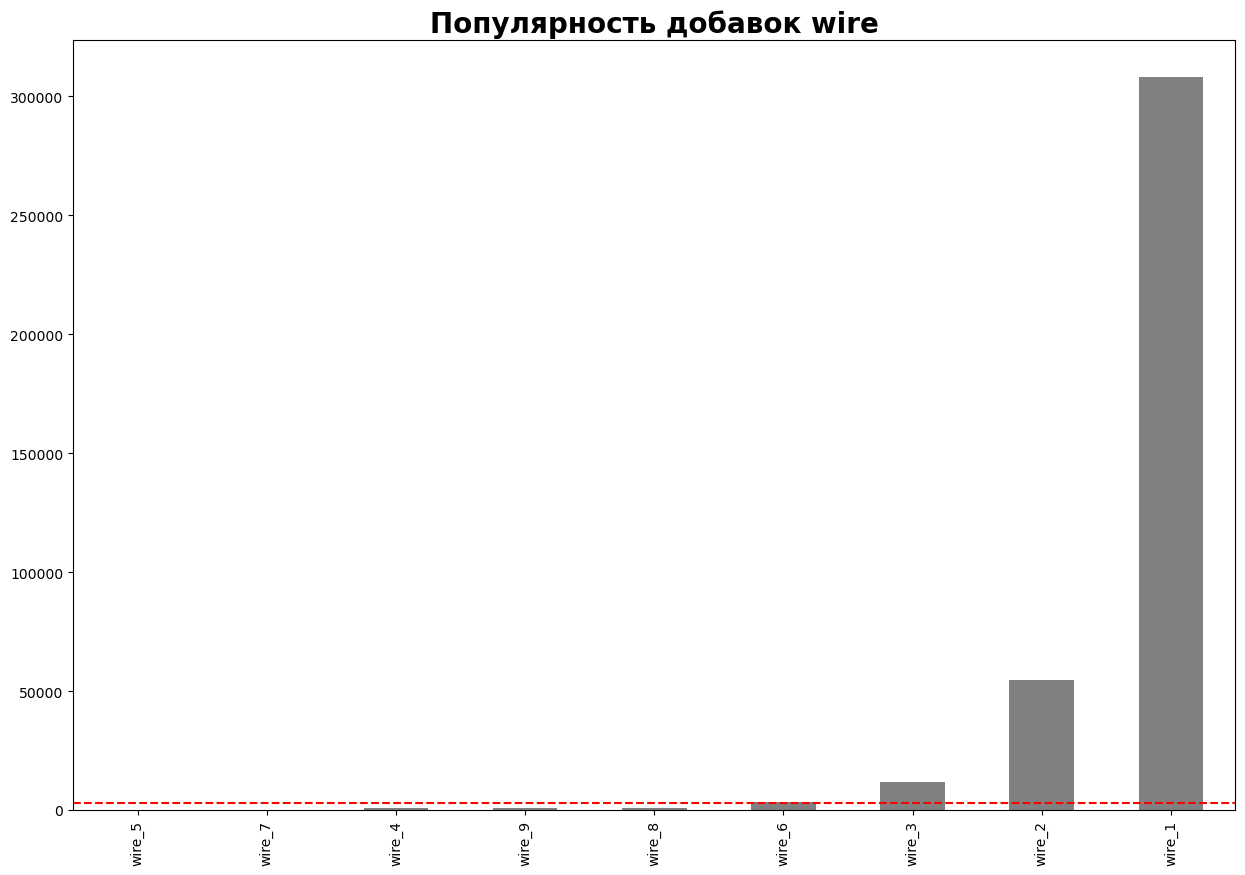

In [95]:
plt.figure(figsize=(15,10))
df_wire.iloc[:, 1:].sum().sort_values().plot(kind='bar', color='gray')
plt.title('Популярность добавок wire', fontweight='bold', fontsize=20)
plt.axhline(y=3000, color='r', linestyle='--')
plt.show()

In [96]:
df_wire['wire_6'].sum()

3505.2390990000004

In [97]:
df_wire['wire_8'].sum()

1018.8786659999998

In [98]:
df_wire_new = df_wire[['key', 'wire_6', 'wire_3', 'wire_2', 'wire_1']]

df_wire_new.head()

,key,wire_6,wire_3,wire_2,wire_1
0,1,0.00,0.00,0.00,60.06
1,2,0.00,0.00,0.00,96.05
2,3,0.00,0.00,0.00,91.16
3,4,0.00,0.00,0.00,89.06
4,5,0.00,0.00,9.11,89.24


**Замечания по работе с признаками:**

Данные об электродах:
- Данные сгруппированы по партиям
- Добавлены новые признаки: полная мощность и энергия
- На тренировочной выборке необходимо очистить столбцы active_power, reactive_power, full_power	и energy от выбросов

Данные о температуре:
- Данные сгруппированы по партиям
- Исследованы партии на количество замеров температур. Оставлены только те партии, в которых есть и начальный, и конечный замер и те партии, в которых температу на начальном замере не равна температуре на конечном замере
- В датасете оставлены только данные о температурах на начальном и конечном замере: first_temp и last_temp

Данные об объёме сыпучих и проволочных материалах:
 - Удалены неинформативные признаки по границе значений в 50000 и 3000 соответственно.


## Объединение датасетов и анализ полученных данных

Мы уже исследовали данные о времени подачи сыпучих и проволочных материалах. Записи в данных соответствуют записям об объёме материалов, поэтому они будут избыточными для модели.

*Мы не будем использовать df_bulk_time и df_wire_time*.

In [99]:
df_full = df_temp_full.merge(df_arc_grouped, how='inner', on=['key'])
df_full = df_full.merge(df_gas, how='inner', on=['key'])
df_full = df_full.merge(df_bulk_new, how='inner', on=['key'])
df_full = df_full.merge(df_wire_new, how='inner', on=['key'])

hello_data(df_full)

,key,first_temp,last_temp,active_power,arc_heating_seconds,energy,full_power,reactive_power,gas,bulk_6,bulk_4,bulk_3,bulk_15,bulk_14,bulk_12,wire_6,wire_3,wire_2,wire_1
0,1,1571.00,1613.00,4.88,430902,501958.14,5.83,3.18,29.75,0.00,43.00,0.00,154.00,150.00,206.00,0.00,0.00,0.00,60.06
1,2,1581.00,1602.00,3.05,344789,314411.06,3.65,2.00,12.56,0.00,73.00,0.00,154.00,149.00,206.00,0.00,0.00,0.00,96.05
2,3,1596.00,1599.00,2.53,431345,257770.68,2.99,1.60,28.55,0.00,34.00,0.00,153.00,152.00,205.00,0.00,0.00,0.00,91.16
3,4,1601.00,1625.00,3.21,344859,328815.84,3.81,2.06,18.84,0.00,81.00,0.00,154.00,153.00,207.00,0.00,0.00,0.00,89.06
4,5,1576.00,1602.00,3.35,344731,347490.34,4.04,2.25,5.41,0.00,78.00,0.00,152.00,151.00,203.00,0.00,0.00,9.11,89.24


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2292 entries, 0 to 2291
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2292 non-null   int64  
 1   first_temp           2292 non-null   float64
 2   last_temp            2292 non-null   float64
 3   active_power         2292 non-null   float64
 4   arc_heating_seconds  2292 non-null   int64  
 5   energy               2292 non-null   float64
 6   full_power           2292 non-null   float64
 7   reactive_power       2292 non-null   float64
 8   gas                  2292 non-null   float64
 9   bulk_6               2292 non-null   float64
 10  bulk_4               2292 non-null   float64
 11  bulk_3               2292 non-null   float64
 12  bulk_15              2292 non-null   float64
 13  bulk_14              2292 non-null   float64
 14  bulk_12              2292 non-null   float64
 15  wire_6               2292 non-null   f

,Процент_пропусков
key,0.0
bulk_4,0.0
wire_2,0.0
wire_3,0.0
wire_6,0.0
bulk_12,0.0
bulk_14,0.0
bulk_15,0.0
bulk_3,0.0
bulk_6,0.0


С итоговой таблицей все в порядке: дубликатов и пропусков не обнаружено.

Проверим взаимосвязи в данных.

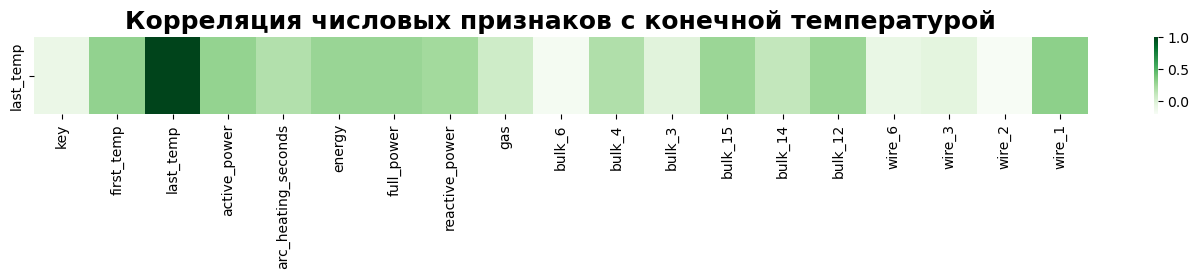

In [100]:
data_corr = df_full.select_dtypes(exclude='object')
data_corr = data_corr.corr()

f, ax = plt.subplots(figsize=(17,1))
sns.heatmap(data_corr.sort_values(by=['last_temp'], ascending=False).head(1), cmap='Greens')
plt.title("Корреляция числовых признаков с конечной температурой", weight='bold', fontsize=18)
plt.show()

Ни один из признаков не имеет сильную взаимосвязь с целевым.

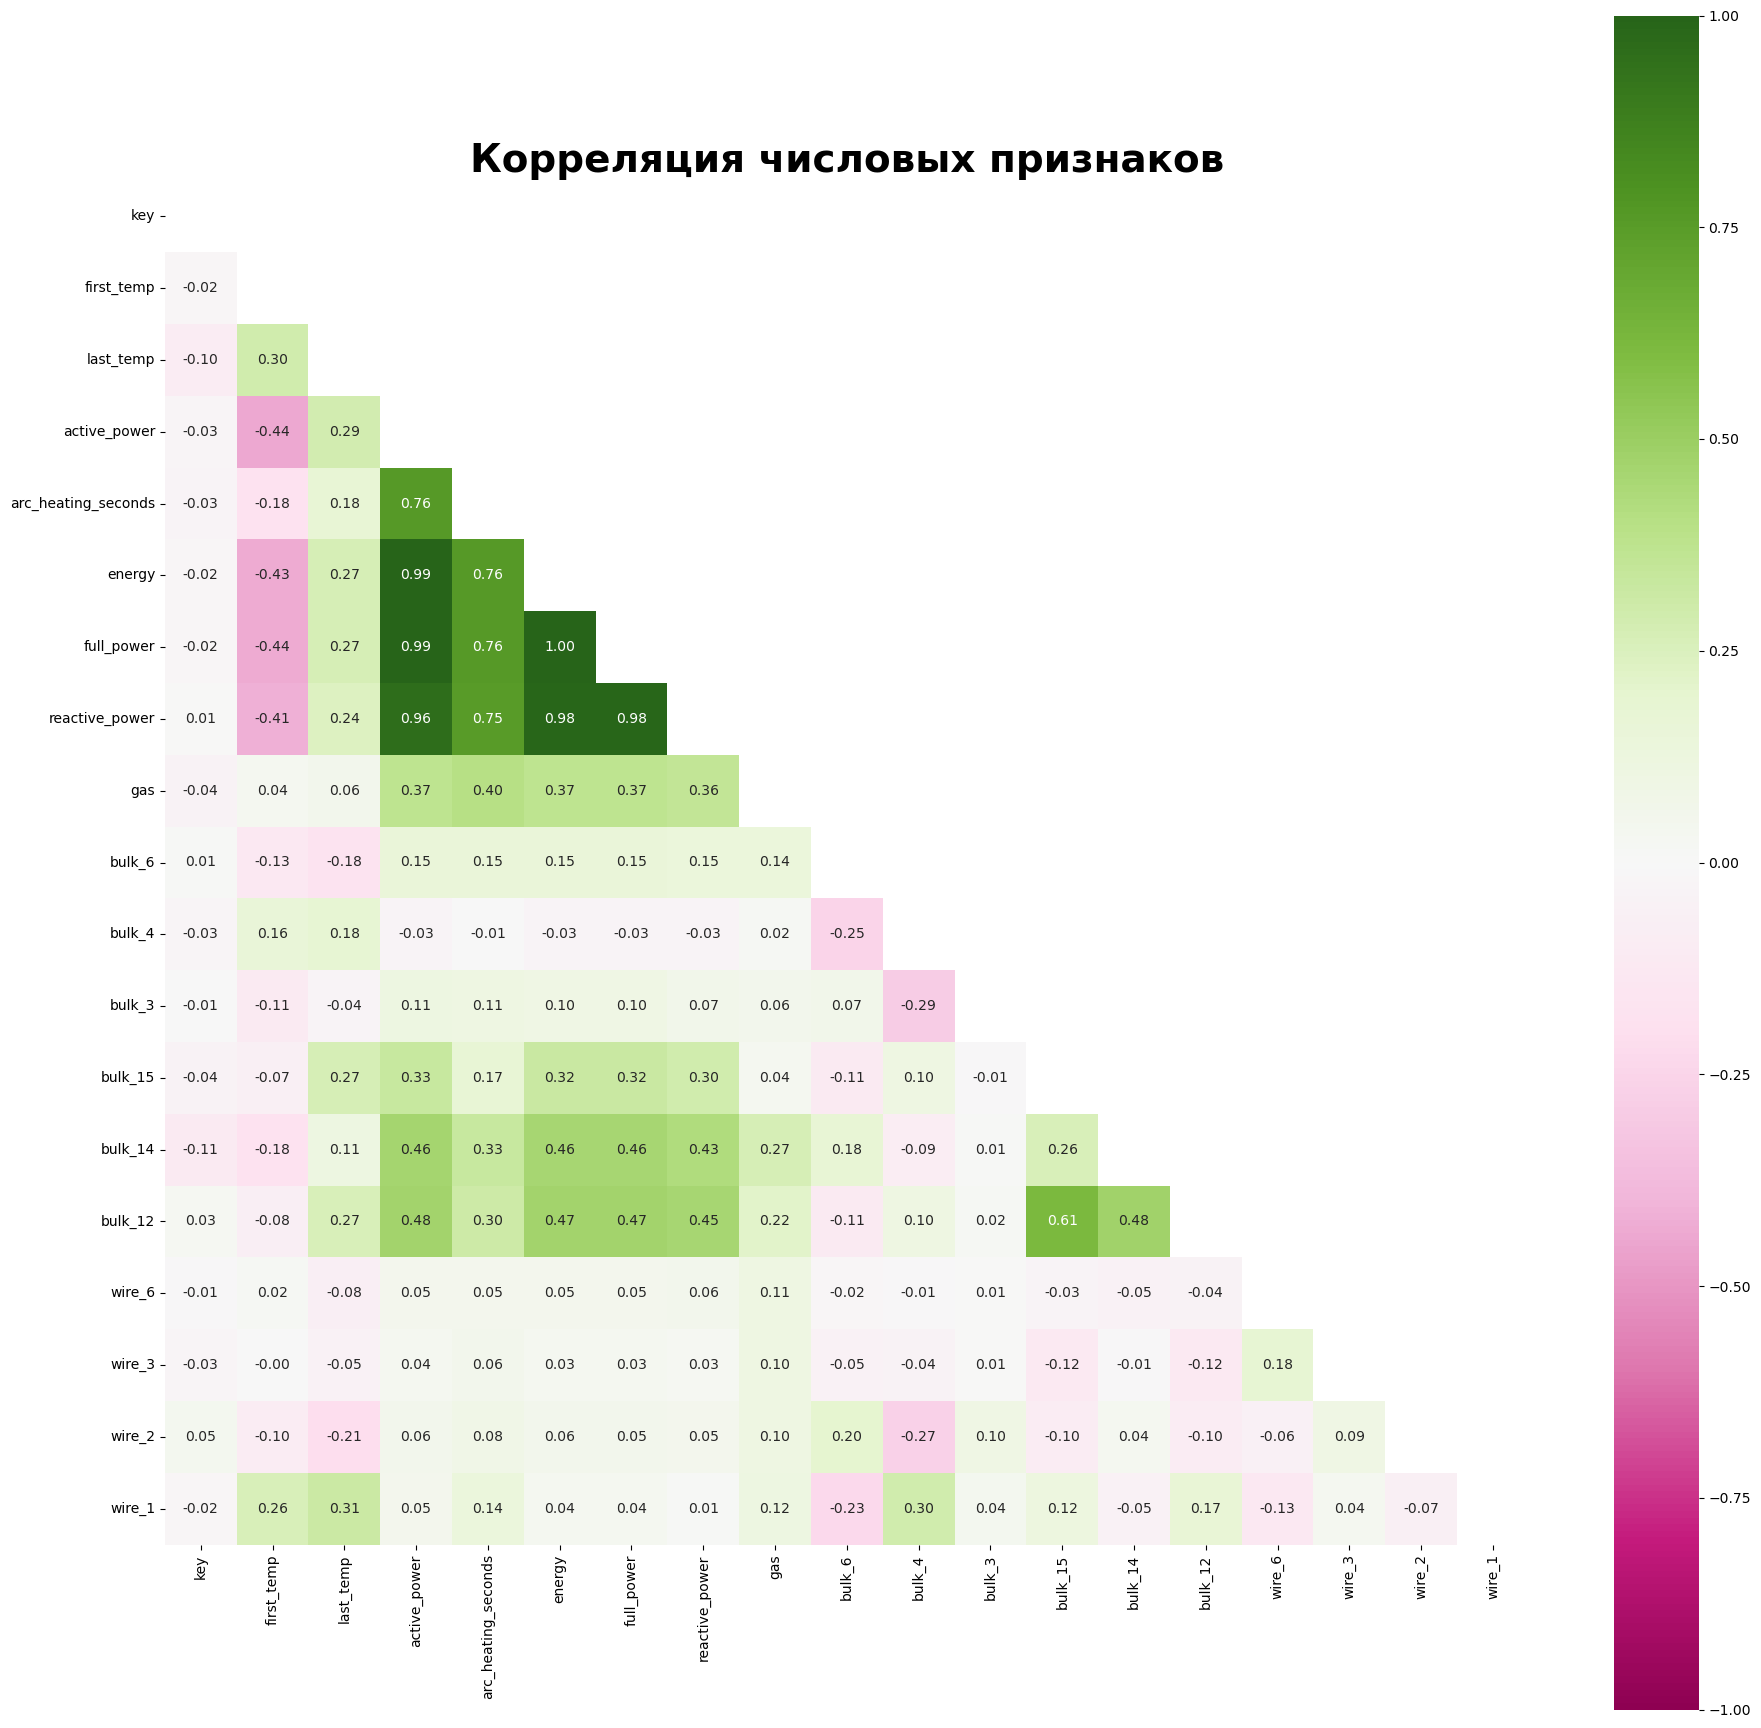

In [101]:
plt.figure(figsize=(22, 22))
matrix = np.triu(df_full.corr())
sns.heatmap(df_full.corr(), annot=True, fmt='.2f', cmap="PiYG", mask=matrix, square=True, vmin=-1, vmax=1, center= 0)
plt.title("Корреляция числовых признаков", weight='bold', fontsize=28)
plt.show()

Мощности, энергия и время нагрева коррелируют друг с другом с высоким модулем коэффициента. Энергия коррелирует с полной мощностью с коэффициентом 1, это может быть критично для модели. 
*Удалим энергию из признаков*. Кроме того, можем *удалить активную и реактивную мощность*: оставим только полную, тк она отражает обе.

Помимо этого можем удалить номер партии 'key'.

In [102]:
df_full = df_full.drop(['energy', 'reactive_power', 'active_power', 'key'], axis=1)

df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2292 entries, 0 to 2291
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   first_temp           2292 non-null   float64
 1   last_temp            2292 non-null   float64
 2   arc_heating_seconds  2292 non-null   int64  
 3   full_power           2292 non-null   float64
 4   gas                  2292 non-null   float64
 5   bulk_6               2292 non-null   float64
 6   bulk_4               2292 non-null   float64
 7   bulk_3               2292 non-null   float64
 8   bulk_15              2292 non-null   float64
 9   bulk_14              2292 non-null   float64
 10  bulk_12              2292 non-null   float64
 11  wire_6               2292 non-null   float64
 12  wire_3               2292 non-null   float64
 13  wire_2               2292 non-null   float64
 14  wire_1               2292 non-null   float64
dtypes: float64(14), int64(1)
memory usage:

**Замечания по созданию итоговой таблицы:**

Для создания итоговой таблицы не использовались данные о времени подачи сыпучих и проволочных материалах

Проверена корреляция признаков по отношению к целевому и друг с другом.
Мощности, энергия и время нагрева имеют сильную взаимосвязь. Из признаков удалена энергия, активная и реактивная мощность. 

Помимо этого данные о начале и конец времени нагрева дугой тоже удалены из основной таблицы.

## Разбитие данных на обучающую и тестовую выборки

In [103]:
# train:test = 3:1
train, test = train_test_split(df_full, test_size=0.25, random_state=RANDOM_STATE)

**Удалим выбросы на тренировочной выборке**

In [104]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1719 entries, 1037 to 1879
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   first_temp           1719 non-null   float64
 1   last_temp            1719 non-null   float64
 2   arc_heating_seconds  1719 non-null   int64  
 3   full_power           1719 non-null   float64
 4   gas                  1719 non-null   float64
 5   bulk_6               1719 non-null   float64
 6   bulk_4               1719 non-null   float64
 7   bulk_3               1719 non-null   float64
 8   bulk_15              1719 non-null   float64
 9   bulk_14              1719 non-null   float64
 10  bulk_12              1719 non-null   float64
 11  wire_6               1719 non-null   float64
 12  wire_3               1719 non-null   float64
 13  wire_2               1719 non-null   float64
 14  wire_1               1719 non-null   float64
dtypes: float64(14), int64(1)
memory usa

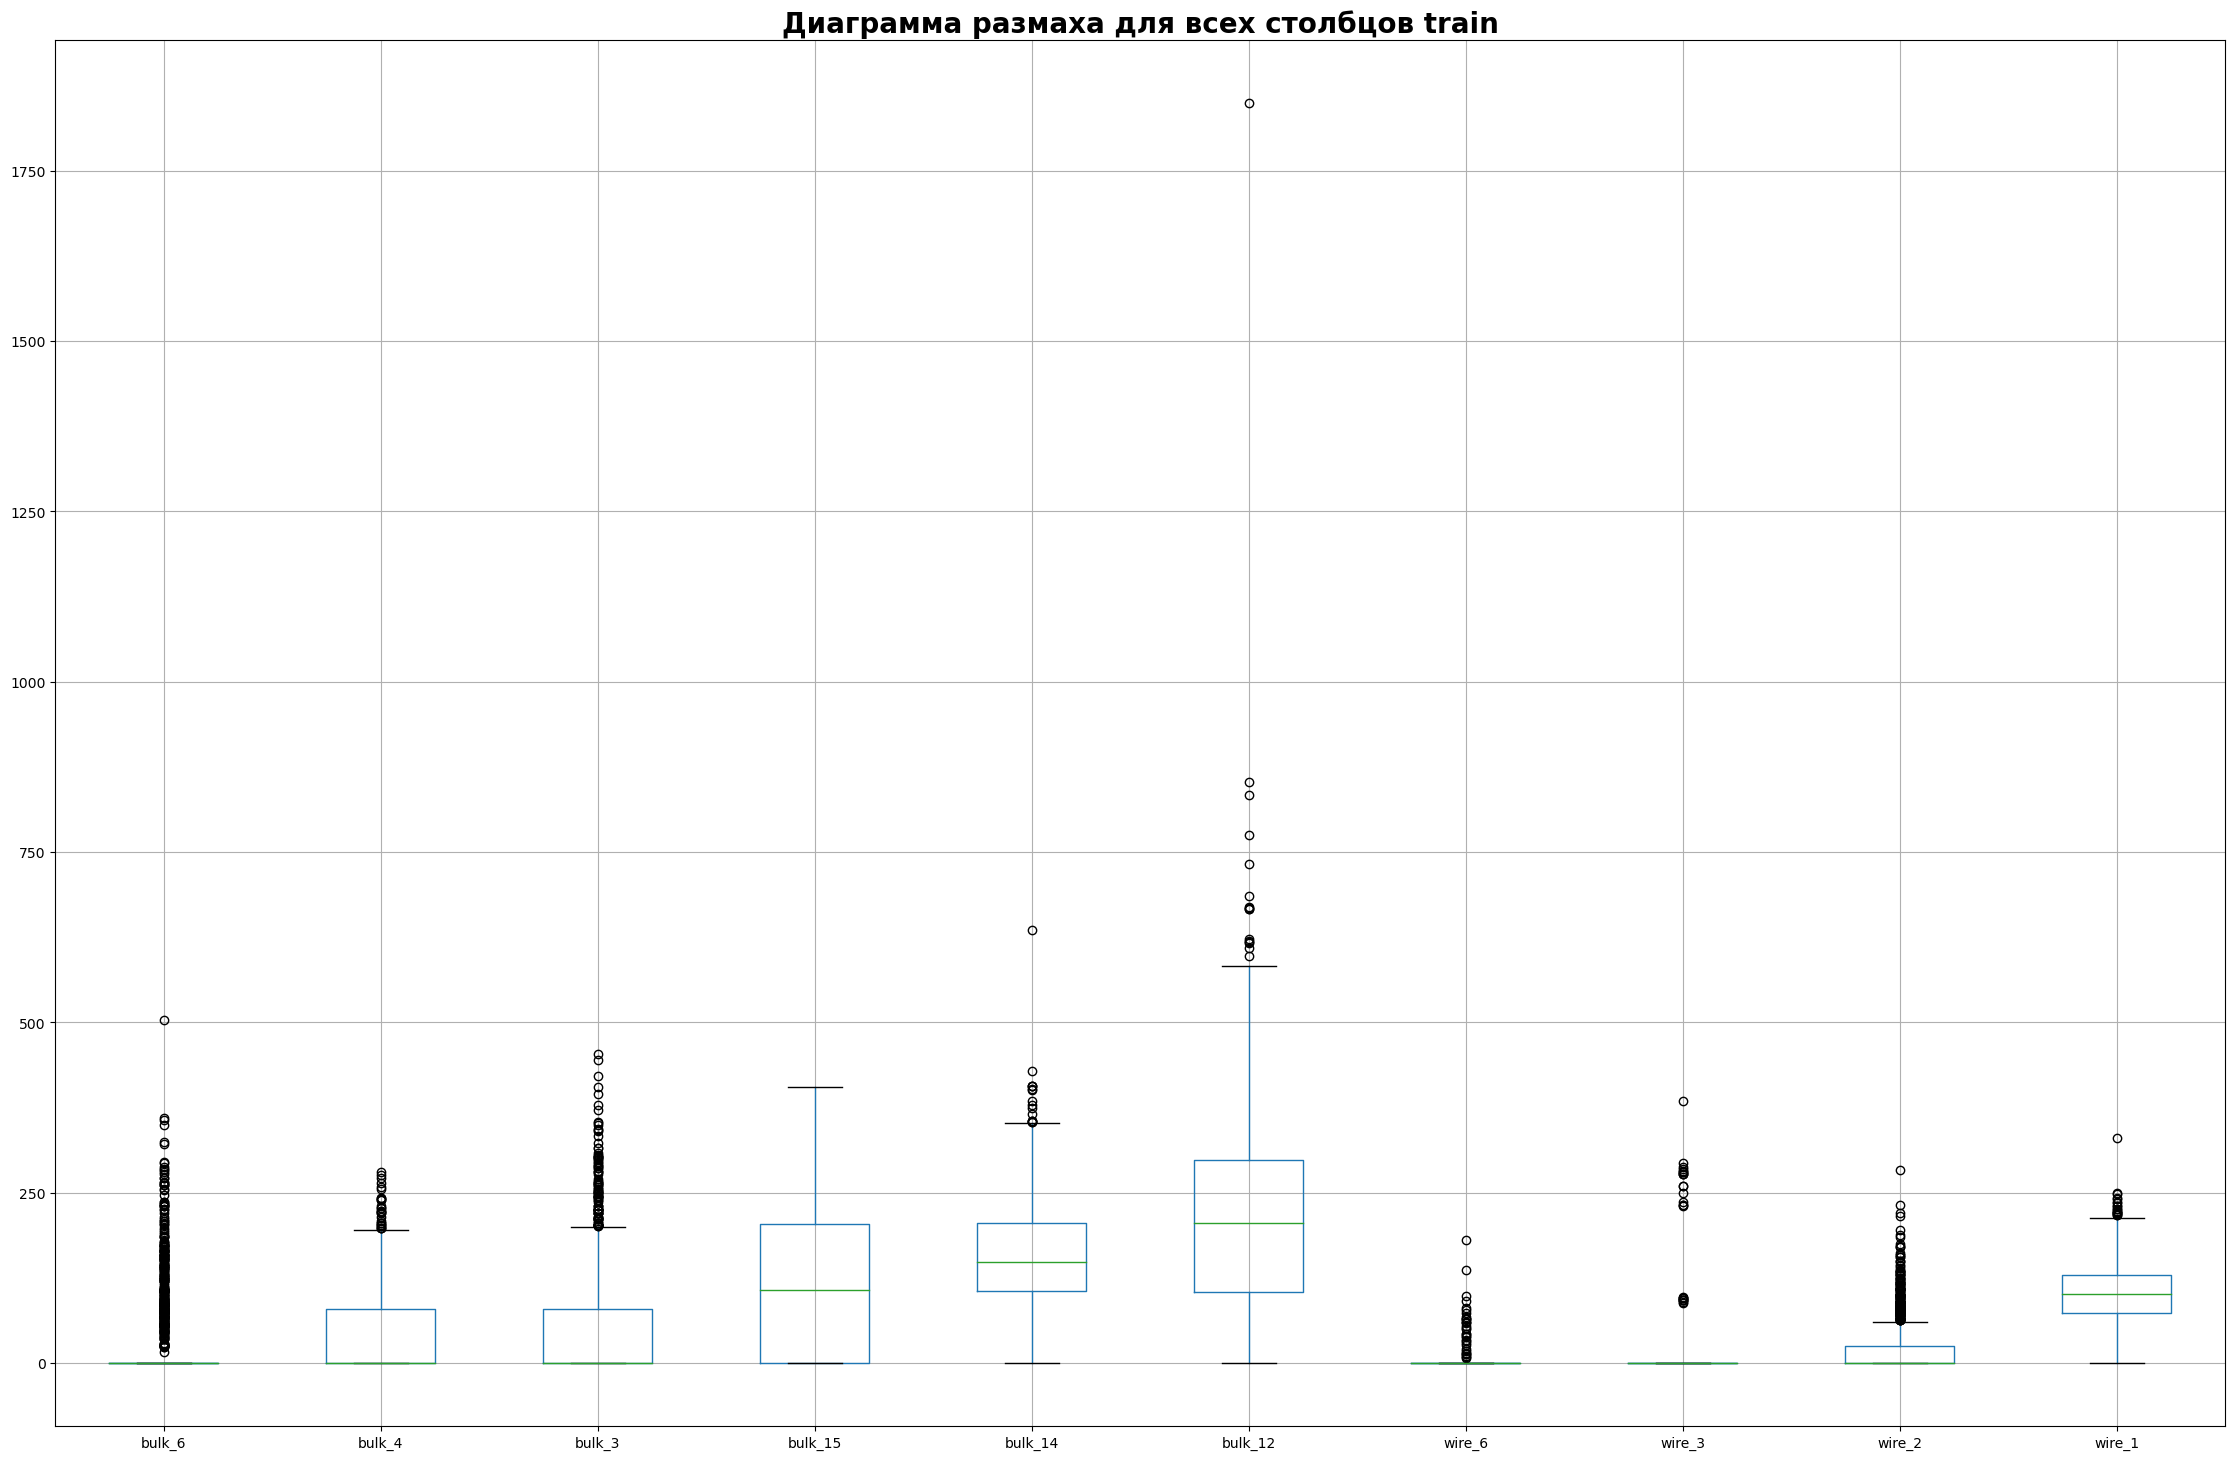

In [105]:
train_check = train.copy()
train_check_2 = train_check.drop(['arc_heating_seconds', 'last_temp', 'full_power', 'gas'], axis=1)

boxplot_full(train_check_2.iloc[:, 0:], 'train')

Мы точно не можем определить границу выбросов, возможно перед нами реальные данные: удалим по единице особо выбивающихся значений.

У wire_3 мало записей и выбросы распределены нехарактерно; *экспериментально в процессе обучения моделей стало ясно, что wire_3 - самый малозначимый признак*. Тк он не обладает важностью, у него мало записей и они странно распределены, данный признак можно удалить.

In [106]:
train = train[(train['bulk_6'] <= 500) & 
              (train['bulk_14'] <= 500) &
              (train['bulk_12'] <= 1000)]

train = train.drop(['wire_3', 'wire_6'], axis=1)
test = test.drop(['wire_3', 'wire_6'], axis=1)


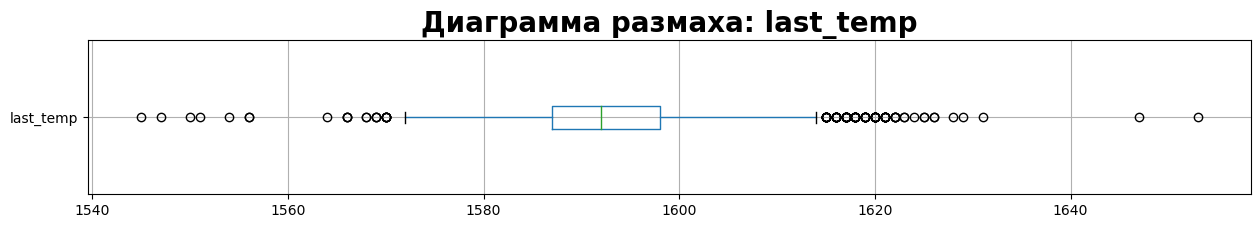

In [107]:
boxplot_col(train, 'last_temp')

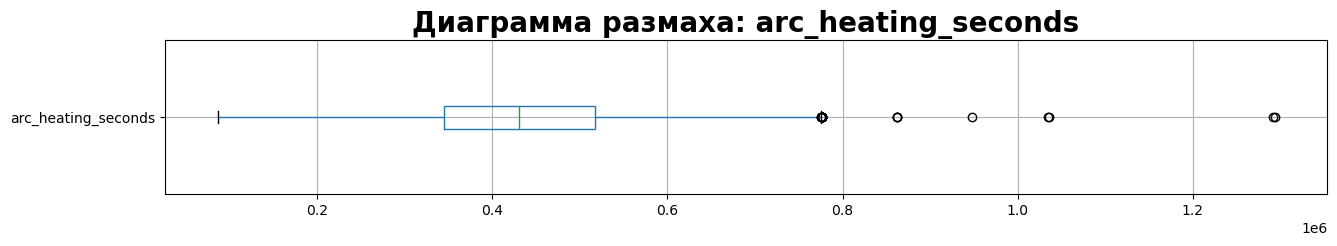

In [108]:
boxplot_col(train, 'arc_heating_seconds')

In [109]:
train['arc_heating_seconds'].max()

1293474

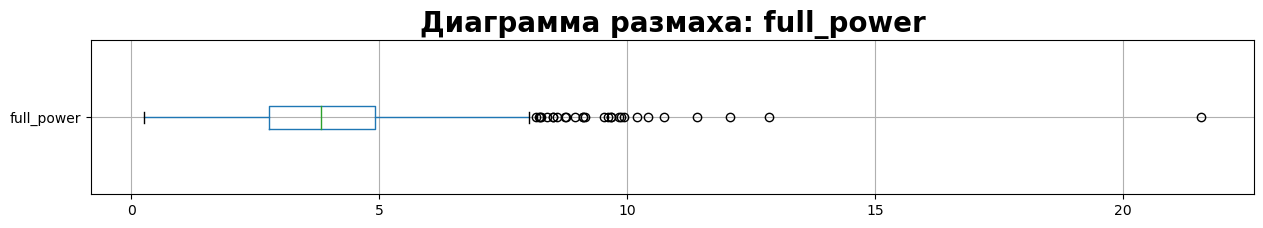

In [110]:
boxplot_col(train, 'full_power')

<!-- Для очистки от выбросов определим следующие границы:
- arc_heating_seconds - 800000 
- full_power - 7 -->

In [111]:
x_train = train.drop(['last_temp'], axis=1)
y_train = train['last_temp']

x_test = test.drop(['last_temp'], axis=1)
y_test = test['last_temp']

In [112]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1717 entries, 1037 to 1879
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   first_temp           1717 non-null   float64
 1   arc_heating_seconds  1717 non-null   int64  
 2   full_power           1717 non-null   float64
 3   gas                  1717 non-null   float64
 4   bulk_6               1717 non-null   float64
 5   bulk_4               1717 non-null   float64
 6   bulk_3               1717 non-null   float64
 7   bulk_15              1717 non-null   float64
 8   bulk_14              1717 non-null   float64
 9   bulk_12              1717 non-null   float64
 10  wire_2               1717 non-null   float64
 11  wire_1               1717 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 174.4 KB


In [113]:
x_train.shape, y_train.shape

((1717, 12), (1717,))

In [114]:
x_test.shape, y_test.shape

((573, 12), (573,))

**Промежуточный итог**

Мы создали итоговую таблицу и разбили её на выборки для обучения моделей.

Проверена корреляция признаков по отношению к целевому и друг с другом. Мощности, энергия и время нагрева имеют сильную взаимосвязь.

Добавлены новые признаки: full_power, first_temp и last_temp
Удалены признаки:  active_power, reactive_power и energy, а также неинформативные признаки о подаче сыпучих и проволочных материалов по границе значений в 50000 и 3000 соответственно.

Для создания итоговой таблицы не использовались данные о времени подачи сыпучих и проволочных материалов. Помимо этого данные о начале и конец времени нагрева дугой тоже удалены из основной таблицы.

Повторно изучены и удалены выбросы из тренировочной выборки. 

Итоговая таблица разбита на тренировочную и тестовую выборки с соотношением 3:1. Выборки разбиты на target и features и готовы к использованию в обучении.

# Обучение моделей

In [115]:
'''
Функция ищет лучшие гиперпараметры с помощью RandomizedSearchCV;
Возвращает лучшую модель, её лучшую метрику и список её гиперпараметров
'''

def search_fit_model(model, params, x, y):
    
    search_results = RandomizedSearchCV(estimator=model, param_distributions=params, 
                                        scoring='neg_mean_absolute_error', cv=CV,
                                       random_state=RANDOM_STATE)
    search_results.fit(x, y)
    
    best_model = search_results.best_estimator_
    best_score = -search_results.best_score_
    best_params = search_results.best_params_
    
    print('Лучшие параметры: ', best_params)
    print('Наилучшая MAE: {:.2f}'.format(best_score))
    
    return best_model, best_score, best_params

In [116]:
'''
Функция ищет лучшие гиперпараметры с помощью OptunaSearchCV;
Возвращает лучшую модель, её лучшую метрику и список её гиперпараметров
'''

def search_fit_model_optuna(model, params, x, y):
    
    search_results = optuna.integration.OptunaSearchCV(model, params, scoring='neg_mean_absolute_error', 
                                                       cv=CV, n_jobs=-1, random_state=RANDOM_STATE,
                                                       n_trials=20, timeout=600)
    search_results.fit(x, y)
    
    best_model = search_results.best_estimator_
    best_score = search_results.best_score_ * (-1)
    best_params = search_results.best_params_
    
    print('Лучшие параметры: ', best_params)
    print('Наилучшая MAE: {:.2f}'.format(best_score))
    
    return best_model, best_score, best_params

**Выявим модели, которые подходят для решения задачи**

Чтобы ускорить работу LazyRegressor, возьмём небольшой sample для обучения.

In [117]:
df_sample = df_full.sample(n=2000, random_state=RANDOM_STATE)

# train:test = 3:1
train_sample, test_sample = train_test_split(df_sample, test_size=0.25, random_state=RANDOM_STATE)

x_train_sample = train_sample.drop(['last_temp'], axis=1)
y_train_sample = train_sample['last_temp']

# Понадобится валидационная выборка
check_features_train, check_features_valid, check_target_train, check_target_valid = train_test_split(
    x_train_sample, y_train_sample, test_size=0.25, random_state=RANDOM_STATE)

In [118]:
LazyRegressor_check = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

models, predictions = LazyRegressor_check.fit(
    check_features_train, check_features_valid, check_target_train, check_target_valid)

display(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:06<00:00,  3.01s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.28,0.30,8.97,0.72
ExtraTreesRegressor,0.27,0.30,9.00,2.64
RandomForestRegressor,0.26,0.29,9.08,1.91
SVR,0.25,0.27,9.15,0.36
NuSVR,0.24,0.27,9.19,0.53
XGBRegressor,0.22,0.25,9.31,1.54
LGBMRegressor,0.20,0.23,9.42,0.44
HistGradientBoostingRegressor,0.19,0.22,9.49,4.72
KNeighborsRegressor,0.19,0.22,9.50,0.10


Лучшее качество показывают модели на основе деревьев решений, в т.ч. бустинговые. Помимо этого в первой десятке есть алгоритмы опорных векторов. Попробуем несколько первых моделей из списка.

Векторные и линейные решения требуют масштабирования признаков.

In [119]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## RandomForestRegressor

In [120]:
RFR = RandomForestRegressor(random_state=RANDOM_STATE)

param_RFR = {'n_estimators': [100, 200, 500],
              'max_features': ['sqrt', 'log2'],
              'max_depth': [10, 20, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

In [121]:
 RFR_model, RFR_score, RFR_params = search_fit_model(RFR, param_RFR, x_train, y_train)

Лучшие параметры:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
Наилучшая MAE: 6.40


## LGBMRegressor

LightGBM основан на алгоритме градиентного бустинга деревьев решений и использует гистограммное разбиение признаков, которое позволяет эффективно работать с признаками различных масштабов, без необходимости их масштабирования.

In [122]:
LGBMR = LGBMRegressor(random_state=RANDOM_STATE, verbose=-1, max_depth=-1)

params_LGBMR = {
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'n_estimators': [20, 30, 40, 50, 60, 70],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'loss': ['ls', 'lad', 'huber', 'quantile']}

In [123]:
LGBMR_model, LGBMR_score, LGBMR_params = search_fit_model(LGBMR, params_LGBMR, x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3

## GradientBoostingRegressor

Gradient Boosting построен на базе деревьев решений, которые не чувствительны к масштабированию признаков.

In [124]:
GBR = GradientBoostingRegressor(random_state=RANDOM_STATE, max_features='auto', loss='huber')

params_GBR = {
    'learning_rate': optuna.distributions.FloatDistribution(0.05, 0.1, 0.15),
    'n_estimators':  optuna.distributions.IntDistribution(50, 100, 150),
    'max_depth': optuna.distributions.IntDistribution(2, 3, 4),
    'min_samples_split': optuna.distributions.IntDistribution(6, 8, 10),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 2, 3)}

In [125]:
GBR_model_2, GBR_score_2, GBR_params_2 =  search_fit_model_optuna(GBR, params_GBR, x_train, y_train)

[I 2023-05-01 14:06:48,928] A new study created in memory with name: no-name-be492696-3e27-42c5-9ae9-919ca00157ea
[I 2023-05-01 14:07:00,296] Trial 0 finished with value: -6.515348683797389 and parameters: {'learning_rate': 0.05811541334216486, 'n_estimators': 52, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: -6.515348683797389.
[I 2023-05-01 14:07:08,646] Trial 2 finished with value: -6.093060351508524 and parameters: {'learning_rate': 0.08861330862280345, 'n_estimators': 67, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 2 with value: -6.093060351508524.
[I 2023-05-01 14:07:10,502] Trial 1 finished with value: -6.175771941918045 and parameters: {'learning_rate': 0.05641156640452224, 'n_estimators': 73, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 2 with value: -6.093060351508524.
[I 2023-05-01 14:07:18,222] Trial 3 finished with value: -6.098293600676098 and parameters: {'lea

Лучшие параметры:  {'learning_rate': 0.0996972583283937, 'n_estimators': 61, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 1}
Наилучшая MAE: 6.05


## SVR

In [126]:
SVR = SVR()

param_svr = {'C': uniform(loc=0, scale=4),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree': [2, 3, 4, 5],
              'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
              'coef0': uniform(loc=0, scale=1),
              'tol': [1e-4, 1e-5, 1e-6],
              'epsilon': [0.1, 0.2, 0.3, 0.4]}

In [127]:
SVR_model, SVR_score, SVR_params = search_fit_model(SVR, param_svr, x_train_scaled, y_train)

Лучшие параметры:  {'C': 1.5000856733980905, 'coef0': 0.9222735810584686, 'degree': 4, 'epsilon': 0.3, 'gamma': 0.1, 'kernel': 'linear', 'tol': 1e-06}
Наилучшая MAE: 6.14


## PoissonRegressor

In [128]:
PR = PoissonRegressor()

param_PR = {'alpha': [0.1, 1.0, 10.0],
            'fit_intercept': [True, False],
            'max_iter': [100, 500, 1000],
            'tol': [1e-4, 1e-3, 1e-2]}


In [129]:
PR_model, PR_score, PR_params = search_fit_model(PR, param_PR, x_train_scaled, y_train)

Лучшие параметры:  {'tol': 0.001, 'max_iter': 1000, 'fit_intercept': True, 'alpha': 0.1}
Наилучшая MAE: 6.18


## LinearRegression

In [130]:
LR = LinearRegression()

param_LR = {'fit_intercept': [True, False],
            'normalize': [True, False],
            'copy_X': [True, False]}


In [131]:
LR_model, LR_score, LR_params = search_fit_model(LR, param_LR, x_train_scaled, y_train)

Лучшие параметры:  {'normalize': False, 'fit_intercept': True, 'copy_X': True}
Наилучшая MAE: 6.18


# Анализ обученных моделей

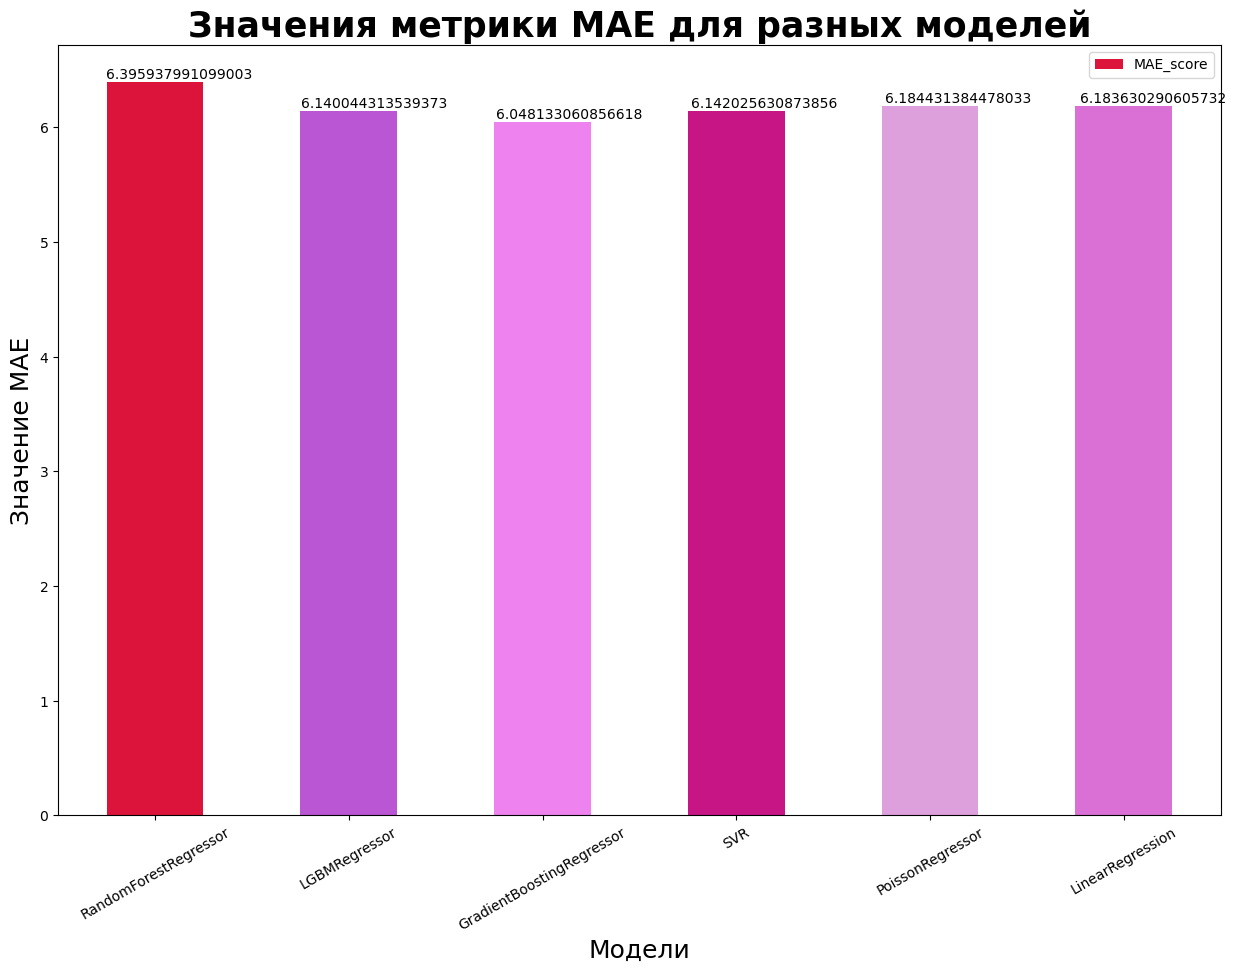

In [132]:
models = {'RandomForestRegressor': RFR_score,
          'LGBMRegressor': LGBMR_score,
          'GradientBoostingRegressor': GBR_score_2,
          'SVR': SVR_score,
          'PoissonRegressor': PR_score,
          'LinearRegression': LR_score}

df_models = pd.DataFrame(
    data=models, 
    index=['MAE_score'])

my_colors = ['crimson', 'mediumorchid', 'violet', 'mediumvioletred', 'plum', 'orchid']

fig = plt.figure(figsize=(15,10))

ax = df_models.iloc[0].plot(kind='bar', rot=30, legend='reverse', color=my_colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    
plt.title(label='Значения метрики MAE для разных моделей', weight='bold', fontsize=25)    
plt.ylabel("Значение MAE", fontsize=18)
plt.xlabel("Модели", fontsize=18)

plt.show()

Все обученные модели показывают хорошие результаты, однако GradientBoostingRegressor показала наилучшую метрику = 6.04

## Важность признаков наилучшей модели

In [133]:
print('Валидация лучшей модели', GBR_score_2)
print(' ')
print('Параметры модели', GBR_params_2)

Валидация лучшей модели 6.048133060856618
 
Параметры модели {'learning_rate': 0.0996972583283937, 'n_estimators': 61, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 1}


In [134]:
# Создаем DataFrame с важностью признаков
feature_importances = pd.DataFrame({'Признак':x_train.columns,'Важность признака':np.round(GBR_model_2.feature_importances_,3)})
feature_importances = feature_importances.sort_values('Важность признака',ascending=False).set_index('Признак')

print(feature_importances.sort_values(by='Важность признака'))

                     Важность признака
Признак                               
bulk_3                            0.01
bulk_4                            0.01
bulk_12                           0.01
bulk_14                           0.01
gas                               0.02
arc_heating_seconds               0.02
bulk_15                           0.06
wire_2                            0.07
wire_1                            0.08
bulk_6                            0.10
full_power                        0.29
first_temp                        0.31


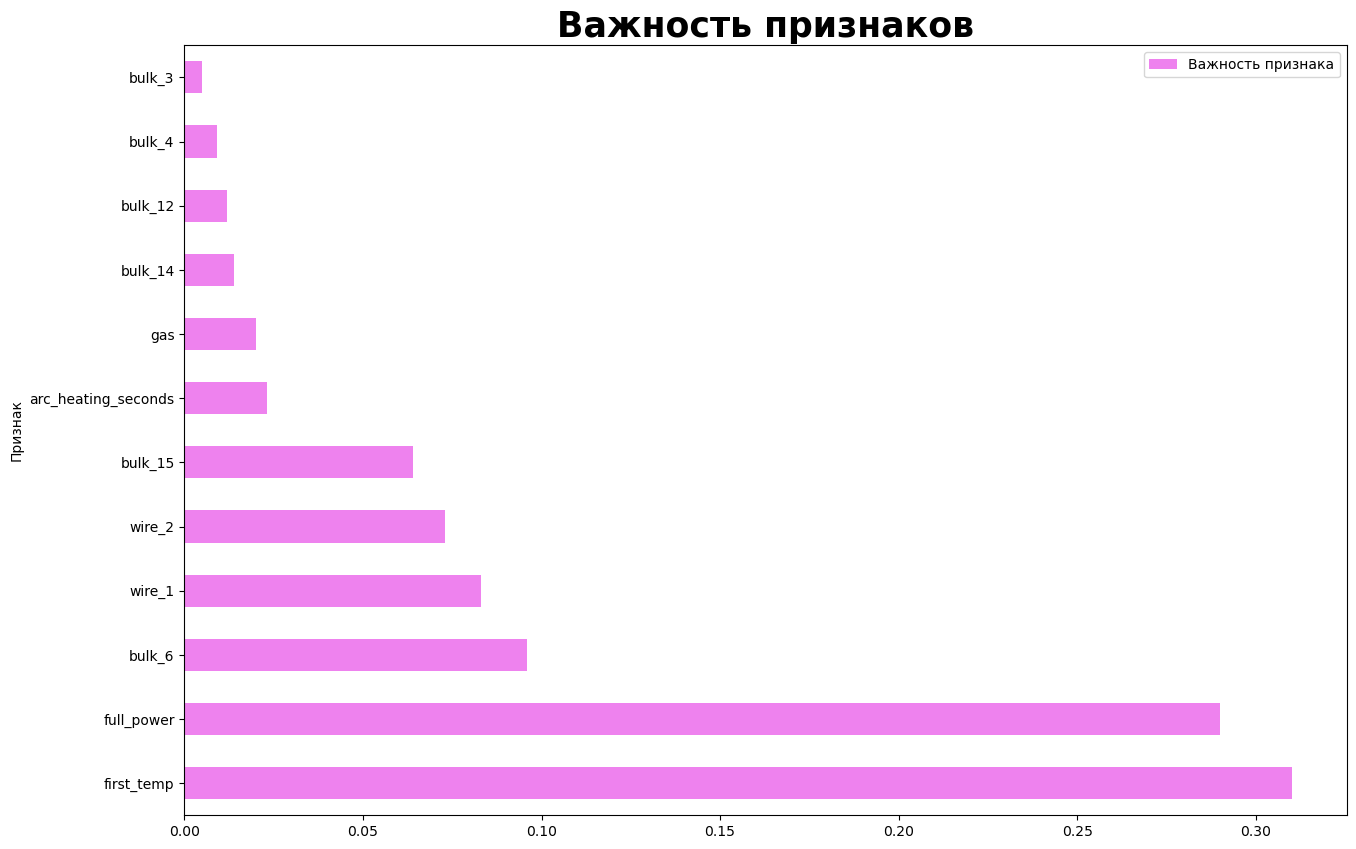

In [135]:
feature_importances.plot.barh(color='violet', figsize=(15, 10))
plt.title('Важность признаков', weight='bold', fontsize=25)    
plt.show()

Самыми важными признаками для модели оказались:
1. Полная мощность
2. Температура на начальном замере

Популярные проволочные и сыпучие добавки  имеют среднюю важность, время нагрева дугой в секундах  и продувка газом - малозначимые признаки.

*Интересное замечание: если удалять малозначимые признаки - качество модели ухудшится.

# Тестирование модели


## Предсказания модели на тестовых данных

In [136]:
GBR_model_pred = GBR_model_2.predict(x_test) 
mae_test = mean_absolute_error(y_test, GBR_model_pred)

print(f'MAE лучшей модели на тестовых данных: {mae_test}')

MAE лучшей модели на тестовых данных: 6.388001832437191


Заметного переобучения модели нет: она показывает примерно одинаковую метрику что на тренировочных, что на тестовых данных.

## Проверка на адекватность

In [137]:
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(x_train, y_train)   

dummy_pred = dummy_reg.predict(x_test)  

print(f'MAE константной модели: {mean_absolute_error(y_test, dummy_pred)}')

MAE константной модели: 8.211032067173456


**Замечание по тестированию модели:**

Модель прошла проверку на адекватность константной моделью и показала хороший результат на тестовых данных.

**Промежуточный итог:**

Для определения пулла решений мы использовали LazyRegressor. Выяснили, что для решения данной задачи подходят решения на основе деревьев решений, в т.ч. бустинговые.

С помощью RandomizedSearchCV мы подобрали гиперпараметры и обучили 6 моделей:
1. RandomForestRegressor
2. LGBMRegressor
3. GradientBoostingRegressor
4. SVR
5. PoissonRegressor
6. LinearRegression

Лучшую метрику показала модель GradientBoostingRegressor

Мы изучили важность признаков при обучении данной модели: самыми важными оказались температура на начальном замере, Полная мощность, данные о продувке газом.

Лучшая модель прошла проверку на адекватность и показала хороший результат на тестовых данных.

# Отчёт по проделанной работе

В решении задачи были выделены следующие **ключевые шаги**:

1. Загрузка данных и предварительный EDA: изучение основной информации о датасетах и обработка данных
2. Глубокий EDA: анализ распределений, взаимосвязей, выбросов
3. Подготовка данных к обучению: генерация признаков, объединение датасетов, разбитие данных на обучающую и тестовую выборки и очистка обучающей выборки.
4. Обучение моделей: подбор гиперпараметров, анализ важности признаков наилучшей модели
Проверка модели: на тестовых данных и на адекватность

**Все пункты плана были выполнены**, однако в процессе работы они были чуть дополнены: использование LazyRegressor и OptunaSearchCV на этапе обучения моделей.

Первое, что мы сделали - это проанализировали данные, чтобы понять, какие преобразования и очистка данных необходимы для последующей подготовки выборок для обучения модели.
Мы начали с изменения названий некоторых столбцов: привели их к нижнему регистру, заменили пробелы на символ _ и использовали латиницу. Это упростило дальнейшую работу с данными, так как у нас было меньше столбцов с разными регистрами и пробелами в названиях.

Далее мы заменили пропуски в данных на нули, так как если материал не подавался, то и записи о нём, соответственно, не было.
Изменили тип данных в некоторых столбцах с "object" на "datetime", чтобы упростить работу с датой и временем.
После этого мы рассмотрели распределение данных, возможные аномалии и выбросы, а также взаимосвязи между признаками.
При анализе данных об электродах и выявили, что осуществлялось несколько стадий нагрева для партии. Активная и реактивная мощности распределены со скошенностью вправо практически идентично, возможно с выбросами. Более того, активная и реактивная мощности имеют сильную положительную линейную корреляцию между друг другом. И, наконец, мы выяснили, что время нагрева дугой колеблется сосредоточено в промежутке от 86.2 тыс сек до 86.3 тыс сек.

Что касается данных о подаче сыпучих и проволочных материалов: некоторые добавки используются очень редко. Самыми используемыми сыпучими добавками являются bulk 12, 14 и 15, проволочными - wire 1 и wire 2.
Продувка сплава газом распределена со скошенностью вправо и с выбросами. Большая часть значений сосредоточена в промежутке от 7 до 13.

Мы много работали над признаками. Например, в данные об электродах были добавлены новые столбцы: время нагрева дугой в секундах, полная мощность и энергия. В датасете с температурой оставили только те партии, в которых есть и начальный, и конечный замер и те партии, в которых температура на начальном замере не равна температуре на конечном замере. Сама температура разбита на начальный замер температуры и конечный замер температуры. По сыпучим и проволочным материалам мы оставили данные только о добавках с границей значений в 50000 и 3000 соответственно. 

Перед объединением данных в 1 таблицу, мы сгруппировали их по ключу, чтобы каждая запись в таблице была уникальной. Мы решили не использовать данные о времени подачи сыпучих и проволочных материалов, тк они не особо информативные, а запись этих таблиц синхронна с таблицами об объёме подачи материалов.

**Самой большой трудностью** в проекте было определить, какие именно признаки нужно оставить для обучения модели. Чтобы **решить этот вопрос**, мы проверили корреляция признаков по отношению к целевому и друг с другом. Здесь мы выяснили, что мощности, энергия и время нагрева имеют сильную взаимосвязь и удалили энергию, активную и реактивную мощности. Мы выбрали именно их, потому что полная мощность отражает сразу 2 мощности, а время нагрева в секундах частично отражает энергию.

Мы создали итоговую таблицу и разбили её на на тренировочную и тестовую выборки с соотношением 3:1. Тренировочная выборка повторно очищена от некоторых выбросов.

Так, в **обучении модели мы использовали следующие признаки:**
- first_temp   
- arc_heating_seconds  
- full_power           
- gas                  
- bulk_6               
- bulk_4               
- bulk_3               
- bulk_15              
- bulk_14              
- bulk_12              
- wire_2               
- wire_1

**Обрабатывались признаки** таким образом:
- first_temp 
Температура плавления была очищена от выбросов по границе в 1400. Начальный замер температуры был получен путём группировки по ключу и агрегирования по минимуму.
- arc_heating_seconds 
Время нагрева дугой было получено путём вычитания из начала нагрева дугой конца нагрева дугой и перевода результата в секунды.
- full_power 
Полная мощность была рассчитана по формуле:
$$S = \sqrt{Q^2 + p^2}$$
- bulk_6 и bulk_14
Урезаны выбросы по границе <= 500
- bulk_12
Урезаны выбросы по границе <= 1000
- Остальные данные передавались без каких-либо изменений.


Удалены признаки:  
- активная, реактивная мощности и энергия 
- начало нагрева дугой и  конец нагрева дугой
- объём: Bulk 1, Bulk 2, Bulk 5, Bulk 7, Bulk 8, Bulk 9, Bulk 10, Bulk 11, Bulk 13
- объём: Wire 3, Wire 4, Wire 5, Wire 6, Wire 7, Wire 8, Wire 9
- время замера температуры 
- ключ key
- время: все данные о подавке сыпучих и проволочных материалов

**Целевой признак** last_temp был очищен от выбросов по границе в 1400. Конечный замер температуры был получен путём группировки по ключу и агрегирования по максимуму.

Перед тем, как приступить к обучению конкретных моделий, мы определили пулл  решений с помощью LazyRegressor: для решения данной задачи подходят решения на основе деревьев решений, в т.ч. бустинговые.

С помощью RandomizedSearchCV и OptunaSearchCV мы подобрали гиперпараметры и обучили 6 моделей:
1. RandomForestRegressor
2. LGBMRegressor
3. GradientBoostingRegressor
4. SVR
5. PoissonRegressor
6. LinearRegression

**Ещё одной трудностью** оказалась необходимость преодоления переобучения модели. Чтобы модель была рабочей и показывала адекватные результаты как на тренировочной, так и на тестовой выборке, мы меньше чистили выбросы в train данных и подбирали гиперпараметры для лучшей модели с OptunaSearchCV.

Лучшую метрику показала модель **GradientBoostingRegressor. Итоговая модель** была проверена на тестовых данных и проверена на адекватность. 

Популярные проволочные и сыпучие добавки как признаки для конкретной модели имеют среднюю важность, время нагрева дугой в секундах  и продувка газом - малозначимые признаки, но если немного почистить данные от малозначимых признаков, качество модели ухудшится. Так что конечные признаки подобраны оптимально.

Лучшая модель была обучена с гиперпараметрами: 
- random_state: 100423, 
- max_features:'auto',
- loss: 'huber'

   $+$

In [138]:
GBR_params_2

{'learning_rate': 0.0996972583283937,
 'n_estimators': 61,
 'max_depth': 3,
 'min_samples_split': 8,
 'min_samples_leaf': 1}

Метрика лучшей модели на тренировочной выборке:

In [139]:
GBR_score_2

6.048133060856618


Метрика лучшей модели на тестовых данных:

In [140]:
mae_test

6.388001832437191

Таким образом, мы построили модель, которая предсказывает температуру стали, и перешли минимальный порог МАЕ, что было требованием заказчика.